This is for modeling model 3, 

3 depth for all sub model, each layer twice from previous layer

# Dependencies

In [1]:
# env HAM
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, roc_auc_score

from sklearn.metrics import confusion_matrix
import seaborn as sns

import optuna, time, random

def set_seed(seed_value=1):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    random.seed(seed_value)

plt.rcParams['font.size'] = 22  # Default font size for all plots
plt.rcParams['axes.titlesize'] = 24  # Title font size
plt.rcParams['axes.labelsize'] = 22  # Axis label font size
plt.rcParams['xtick.labelsize'] = 20  # X-tick label size
plt.rcParams['ytick.labelsize'] = 20  # Y-tick label size
plt.rcParams['legend.fontsize'] = 20  # Legend font size
plt.rcParams['figure.figsize'] = (10, 8)  # Default figure size
plt.rcParams['lines.linewidth'] = 2  # Line width for plots

set_seed(42)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Helper Functions

In [3]:
def collect_images_path(base_dirs):
    image_paths = []
    for base_dir in base_dirs:
        for root, _, files in os.walk(base_dir):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.png'):
                    rel_dir = os.path.relpath(root, base_dir)
                    rel_file = os.path.join(rel_dir, file)
                    image_paths.append((base_dir, rel_file))
    return image_paths

def process_images(image_paths, enhancement_func, enhancement_name):
    for base_dir, rel_path in image_paths:
        with Image.open(os.path.join(base_dir, rel_path)) as img:
            enhanced_img = enhancement_func(img)
            
            # Membuat jalur output
            output_base_dir = os.path.join(enhancement_name, os.path.dirname(rel_path))
            output_path = os.path.join(output_base_dir, os.path.basename(rel_path))
            os.makedirs(os.path.dirname(output_path), exist_ok=True)

            enhanced_img.save(output_path)
            print(f"Saved image to: {output_path}")

def calculate_average(image_paths):
    widhts, heights = [], []
    for base_dir, rel_path in image_paths:
        with Image.open(os.path.join(base_dir, rel_path)) as img:
            widhts.append(img.width)
            heights.append(img.height)
    avg_width = int(np.mean(widhts))
    avg_height = int(np.mean(heights))
    return avg_width, avg_height

def resize_images(image_paths, target_size, output_base_dirs, base_dirs):
    for base_dir, rel_path in image_paths:
        with Image.open(os.path.join(base_dir, rel_path)) as img:
            resized_img = img.resize(target_size, Image.LANCZOS)
            output_base_dir = output_base_dirs[base_dirs.index(base_dir)]
            output_path = os.path.join(output_base_dir, rel_path)
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            resized_img.save(output_path)

# Get image size and resize

In [4]:
base_dirs = ['images per part\Left', 'images per part\Right']
output_base_dirs = ['Image enhancement\images resized\Left', 'Image enhancement\images resized\Right']

image_paths = collect_images_path(base_dirs)

avg_width, avg_height = calculate_average(image_paths)
target_size = (avg_width, avg_height)

# resize_images(image_paths, target_size, output_base_dirs, base_dirs)

print(f"Resizing complete. Average size: {avg_width}x{avg_height}")

Resizing complete. Average size: 64x149


In [5]:
p, l = avg_width, avg_height

## Helper preprocessing

In [6]:
def preprocess_termogram(data, target_size=(p, l)):
    data_resized = resize(data, target_size)
    preprocessed_data = data_resized / 255.0  # Normalisasi
    return preprocessed_data

# Fungsi untuk data tabular
def preprocess_tabular(data):
    scaler = StandardScaler()
    preprocessed_data = scaler.fit_transform(np.array(data))
    return preprocessed_data

def create_labels(data_tabular):
    labels = data_tabular['Subject'].apply(lambda x: 1 if x.startswith('DM') else 0)
    data_tabular['label'] = labels
    return data_tabular

def convert_gender_to_numeric(data_tabular):
    data_tabular['Gender'] = data_tabular['Gender'].map({'M': 1, 'F': 0})
    return data_tabular

# Tabular preprocess

In [7]:
data_tabular = pd.read_csv("Plantar Thermogram Data Analysis.csv", delimiter=";")
create_labels(data_tabular)

,Subject,Gender,General_right,LCA_right,LPA_right,MCA_right,MPA_right,TCI_right,General_left,LCA_left,LPA_left,MCA_left,MPA_left,TCI_left,label
0,DM001,M,32.47,32.08,32.70,32.36,32.79,6.48,32.09,31.53,32.39,31.81,32.39,6.03,1
1,DM002,M,26.99,26.54,26.95,26.84,27.38,0.93,26.33,26.39,25.93,26.75,26.45,0.38,1
2,DM003,F,28.04,28.22,27.57,29.06,27.70,2.14,27.19,26.96,26.96,27.90,27.38,1.30,1
3,DM004,M,32.32,31.67,32.54,31.86,32.61,6.17,30.71,29.78,30.96,31.04,30.72,4.62,1
4,DM005,M,24.48,24.19,24.48,24.26,24.52,1.64,25.36,24.40,25.72,24.88,25.57,0.87,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,CG041,F,27.11,27.15,26.94,26.95,27.06,1.03,27.61,27.64,27.21,27.45,27.48,1.44,0
163,CG042,F,25.66,25.45,25.34,26.20,25.80,0.30,25.73,25.15,25.72,25.89,25.80,0.37,0
164,CG043,M,24.87,26.03,23.78,26.72,24.16,0.99,24.47,25.59,23.90,26.14,23.48,1.22,0
165,CG044,F,22.39,23.12,21.63,23.63,21.53,3.52,22.03,22.81,21.27,23.13,21.35,3.86,0


# Load termogram and pipeline

In [8]:
def load_termogram_images(data_tabular, img_dir):
    termograms_left = []
    termograms_right = []
    for i, row in data_tabular.iterrows():
        subjek_id = row['Subject']
        gender = row['Gender']
        
        if subjek_id.startswith('DM'):
            left_folder = 'DM Left'
            right_folder = 'DM Right'
        elif subjek_id.startswith('CG'):
            left_folder = 'CG Left'
            right_folder = 'CG Right'
        else:
            continue

        img_path_left = os.path.join(img_dir, 'Left', left_folder, f'{subjek_id}_{gender}_L.png')
        img_path_right = os.path.join(img_dir, 'Right', right_folder, f'{subjek_id}_{gender}_R.png')
        
        # Check if files exist, else skip
        if not os.path.exists(img_path_left) or not os.path.exists(img_path_right):
            print(f"Files for {subjek_id} not found.")
            continue
        
        img_left = imread(img_path_left)
        img_right = imread(img_path_right)
        
        img_left = preprocess_termogram(img_left)
        img_right = preprocess_termogram(img_right)
        
        termograms_left.append(img_left)
        termograms_right.append(img_right)
    
    return np.array(termograms_left), np.array(termograms_right)

def run_model_pipeline(img_dir):
    try:
        termograms_left, termograms_right = load_termogram_images(data_tabular, img_dir)

        data_tabular_numeric = convert_gender_to_numeric(data_tabular.copy())
        tabular_data = data_tabular_numeric.drop(columns=['Subject', 'label']).values
        
        data_tabular_numeric = create_labels(data_tabular)
        labels = data_tabular_numeric['label'].values

        # Train-test split
        X_train_termogram_left, X_test_termogram_left, X_train_termogram_right, X_test_termogram_right, X_train_tabular, X_test_tabular, y_train, y_test = train_test_split(
            termograms_left, termograms_right, tabular_data, labels, test_size=0.2, random_state=1)

        print(f"Ukuran train dan test data termogram kaki kiri: {X_train_termogram_left.shape, X_test_termogram_left.shape}")
        print(f"Ukuran train dan test data termogram kaki kanan: {X_train_termogram_right.shape, X_test_termogram_right.shape}")
        print(f"Ukuran train dan test data tabular: {X_train_tabular.shape, X_test_tabular.shape}")
        print(f"Ukuran label: {y_train.shape, y_test.shape}")
        
        # Preprocessing
        scaler = StandardScaler()

        X_train_tabular_scaled = scaler.fit_transform(X_train_tabular)
        X_test_tabular_scaled = scaler.transform(X_test_tabular)

        return termograms_left, termograms_right, \
            tabular_data, labels, X_train_termogram_left, \
                X_test_termogram_left, X_train_termogram_right, \
                    X_test_termogram_right, X_train_tabular_scaled, \
                        X_test_tabular_scaled, y_train, y_test
        
    except Exception as e:
        print("Terjadi error, membersihkan sesi TensorFlow...")
        tf.keras.backend.clear_session()
        print(f"Error yang terjadi: {e}")

# Base model

## Model 1
1 depth for all sub model

In [9]:
# def create_model(p, l, tabular_shape):
#     # Left image input
#     input_left = layers.Input(shape=(p, l, 3))

#     conv1_left = layers.Conv2D(64, (3, 3))(input_left)
#     relu1_left = layers.Activation('relu')(conv1_left)
#     pool1_left = layers.MaxPooling2D(pool_size=(2, 2))(relu1_left)
#     batch1_left = layers.BatchNormalization()(pool1_left)
    
#     flatten_left = layers.Flatten()(batch1_left)

#     # Right image input
#     input_right = layers.Input(shape=(p, l, 3))

#     conv1_right = layers.Conv2D(64, (3, 3), activation='relu')(input_right)
#     relu1_right = layers.Activation('relu')(conv1_right)
#     pool1_right = layers.MaxPooling2D(pool_size=(2, 2))(relu1_right)
#     batch1_right = layers.BatchNormalization()(pool1_right)
    
#     flatten_right = layers.Flatten()(batch1_right)

#     # Tabular input
#     input_tabular = layers.Input(shape=(tabular_shape,))
#     dense1_tabular = layers.Dense(64, activation='relu')(input_tabular)
#     # dense2_tabular = layers.Dense(128, activation='relu')(dense1_tabular)
#     # dense3_tabular = layers.Dense(256, activation='relu')(dense2_tabular)
#     drop1_tabular = layers.Dropout(0.5)(dense1_tabular)

#     # Concatenate features from image and tabular data
#     concat = layers.concatenate([flatten_left, flatten_right, drop1_tabular])

#     # Fully connected layers for the combined output
#     dense1 = layers.Dense(32, activation='relu', kernel_regularizer='l2')(concat)
#     drop1 = layers.Dropout(0.2)(dense1)

#     dense2 = layers.Dense(64, activation='relu', kernel_regularizer='l2')(drop1)
#     drop2 = layers.Dropout(0.2)(dense2)

#     dense3 = layers.Dense(128, activation='relu', kernel_regularizer='l2')(drop2)
#     drop3 = layers.Dropout(0.2)(dense3)

#     # Combined final output
#     output = layers.Dense(1, activation='sigmoid')(drop3)

#     # Create the model with multiple outputs
#     model = models.Model(inputs=[input_left, input_right, input_tabular], outputs=output)
#     return model

## Model 2
2 depth for all sub-model (undone)

In [10]:
# def create_model(p, l, tabular_shape):
#     # Left image input
#     input_left = layers.Input(shape=(p, l, 3))

#     conv1_left = layers.Conv2D(64, (3, 3))(input_left)
#     relu1_left = layers.Activation('relu')(conv1_left)
#     pool1_left = layers.MaxPooling2D(pool_size=(2, 2))(relu1_left)
#     batch1_left = layers.BatchNormalization()(pool1_left)
    
#     flatten_left = layers.Flatten()(batch1_left)

#     # Right image input
#     input_right = layers.Input(shape=(p, l, 3))

#     conv1_right = layers.Conv2D(64, (3, 3), activation='relu')(input_right)
#     relu1_right = layers.Activation('relu')(conv1_right)
#     pool1_right = layers.MaxPooling2D(pool_size=(2, 2))(relu1_right)
#     batch1_right = layers.BatchNormalization()(pool1_right)
    
#     flatten_right = layers.Flatten()(batch1_right)

#     # Tabular input
#     input_tabular = layers.Input(shape=(tabular_shape,))
#     dense1_tabular = layers.Dense(64, activation='relu')(input_tabular)
#     # dense2_tabular = layers.Dense(128, activation='relu')(dense1_tabular)
#     # dense3_tabular = layers.Dense(256, activation='relu')(dense2_tabular)
#     drop1_tabular = layers.Dropout(0.5)(dense3_tabular)

#     # Concatenate features from image and tabular data
#     concat = layers.concatenate([flatten_left, flatten_right, drop1_tabular])

#     # Fully connected layers for the combined output
#     dense1 = layers.Dense(32, activation='relu', kernel_regularizer='l2')(concat)
#     drop1 = layers.Dropout(0.2)(dense1)

#     dense2 = layers.Dense(64, activation='relu', kernel_regularizer='l2')(drop1)
#     drop2 = layers.Dropout(0.2)(dense2)

#     dense3 = layers.Dense(128, activation='relu', kernel_regularizer='l2')(drop2)
#     drop3 = layers.Dropout(0.2)(dense3)

#     # Combined final output
#     output = layers.Dense(1, activation='sigmoid')(drop3)

#     # Create the model with multiple outputs
#     model = models.Model(inputs=[input_left, input_right, input_tabular], outputs=output)
#     return model


## Model 3

In [11]:
def create_model(p, l, tabular_shape):
    # Left image input
    input_left = layers.Input(shape=(p, l, 3))

    conv1_left = layers.Conv2D(64, (3, 3))(input_left)
    relu1_left = layers.Activation('relu')(conv1_left)
    pool1_left = layers.MaxPooling2D(pool_size=(2, 2))(relu1_left)
    batch1_left = layers.BatchNormalization()(pool1_left)

    conv2_left = layers.Conv2D(128, (3, 3))(batch1_left)
    relu2_left = layers.Activation('relu')(conv2_left)
    pool2_left = layers.MaxPooling2D(pool_size=(2, 2))(relu2_left)
    batch2_left = layers.BatchNormalization()(pool2_left)
    
    conv3_left = layers.Conv2D(256, (3, 3))(batch2_left)
    relu3_left = layers.Activation('relu')(conv3_left)
    pool3_left = layers.MaxPooling2D(pool_size=(2, 2))(relu3_left)
    batch3_left = layers.BatchNormalization()(pool3_left)

    flatten_left = layers.Flatten()(batch3_left)

    # Right image input
    input_right = layers.Input(shape=(p, l, 3))

    conv1_right = layers.Conv2D(64, (3, 3))(input_right)
    relu1_right = layers.Activation('relu')(conv1_right)
    pool1_right = layers.MaxPooling2D(pool_size=(2, 2))(relu1_right)
    batch1_right = layers.BatchNormalization()(pool1_right)
    
    conv2_right = layers.Conv2D(128, (3, 3))(batch1_right)
    relu2_right = layers.Activation('relu')(conv2_right)
    pool2_right = layers.MaxPooling2D(pool_size=(2, 2))(relu2_right)
    batch2_right = layers.BatchNormalization()(pool2_right)

    conv3_right = layers.Conv2D(256, (3, 3))(batch2_right)
    relu3_right = layers.Activation('relu')(conv3_right)
    pool3_right = layers.MaxPooling2D(pool_size=(2, 2))(relu3_right)
    batch3_right = layers.BatchNormalization()(pool3_right)

    flatten_right = layers.Flatten()(batch3_right)

    # Tabular input
    input_tabular = layers.Input(shape=(tabular_shape,))
    dense1_tabular = layers.Dense(64, activation='relu')(input_tabular)
    dense2_tabular = layers.Dense(128, activation='relu')(dense1_tabular)
    dense3_tabular = layers.Dense(256, activation='relu')(dense2_tabular)
    drop1_tabular = layers.Dropout(0.5)(dense3_tabular)

    # Concatenate features from image and tabular data
    concat = layers.concatenate([flatten_left, flatten_right, drop1_tabular])

    # Fully connected layers for the combined output
    dense1 = layers.Dense(32, activation='relu', kernel_regularizer='l2')(concat)
    drop1 = layers.Dropout(0.2)(dense1)

    dense2 = layers.Dense(64, activation='relu', kernel_regularizer='l2')(drop1)
    drop2 = layers.Dropout(0.2)(dense2)

    dense3 = layers.Dense(128, activation='relu', kernel_regularizer='l2')(drop2)
    drop3 = layers.Dropout(0.2)(dense3)

    # Combined final output
    output = layers.Dense(1, activation='sigmoid')(drop3)

    # Create the model with multiple outputs
    model = models.Model(inputs=[input_left, input_right, input_tabular], outputs=output)
    return model


## Helper Experiment

In [12]:
def run_experiment(img_dir, epochs=200, learning_rate=0.0001):
    # Menjalankan pipeline model dengan img_dir yang diberikan
    termograms_left, termograms_right,\
    tabular_data, labels,\
    X_train_termogram_left, X_test_termogram_left,\
    X_train_termogram_right, X_test_termogram_right,\
    X_train_tabular, X_test_tabular,\
    y_train, y_test = run_model_pipeline(img_dir)

    p, l = termograms_left.shape[1], termograms_left.shape[2]
    tabular_shape = tabular_data.shape[1]
    model = create_model(p, l, tabular_shape)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    history = model.fit(
        [X_train_termogram_left, X_train_termogram_right, X_train_tabular], 
        y_train, 
        epochs=epochs,
        validation_data=([X_test_termogram_left, X_test_termogram_right, X_test_tabular], y_test),
        verbose=0
        # callbacks=[lr_scheduler]
        )
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time} seconds")

    return history, model,\
        termograms_left, termograms_right, tabular_data, labels,\
        X_train_termogram_left, X_test_termogram_left,\
        X_train_termogram_right, X_test_termogram_right,\
        X_train_tabular, X_test_tabular,\
        y_train, y_test

## Helper function for evaluation

In [13]:
def evaluate_model(model, X_train_left, X_train_right, X_train_tabular, y_train, 
                   X_test_left, X_test_right, X_test_tabular, y_test, history):
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate([X_test_termogram_left, X_test_termogram_right, X_test_tabular], y_test, verbose=0)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

    # Evaluate on training set
    train_loss, train_accuracy = model.evaluate([X_train_termogram_left, X_train_termogram_right, X_train_tabular], y_train, verbose=0)
    print(f"Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")

    # Predict probabilities and binary class for test set
    start_time = time.time()
    y_pred_prob = model.predict([X_test_termogram_left, X_test_termogram_right, X_test_tabular])
    end_time = time.time()
    inference_time = end_time - start_time
    print(f"Inference time for one sample: {inference_time} seconds")
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Diabetes', 'Diabetes'], 
                yticklabels=['Non-Diabetes', 'Diabetes'])
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot ROC curve and calculate ROC AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print(f'ROC AUC: {roc_auc:.4f}')

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Plot training history
    plot_history(history)

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Plot for Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')  # Label sumbu X
    plt.ylabel('Accuracy')  # Label sumbu Y

    # Plot for Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')  # Label sumbu X
    plt.ylabel('Loss')  # Label sumbu Y

    plt.tight_layout()
    plt.show()



## Helper function for k-fold

In [14]:
def k_fold_cross_validation(model_fn, termograms_left, termograms_right, tabular_data, labels, n_splits=5, epochs=200):
    # Initialize KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # List to store metrics for each fold
    accuracies, precisions, recalls, f1_scores, aucs = [], [], [], [], []
    
    # Loop over each fold
    fold = 1
    for train_index, test_index in kf.split(termograms_left):
        print(f"Results for fold {fold}")
        
        # Split the data
        X_train_left, X_test_left = termograms_left[train_index], termograms_left[test_index]
        X_train_right, X_test_right = termograms_right[train_index], termograms_right[test_index]
        X_train_tabular, X_test_tabular = tabular_data[train_index], tabular_data[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        # Recreate and compile a new model for each fold to ensure independence
        model = model_fn(X_train_left.shape[1], X_train_left.shape[2], X_train_tabular.shape[1])

        model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

        # Train the model
        model.fit([X_train_left, X_train_right, X_train_tabular], y_train, epochs=epochs, verbose=0)

        # Predict the model
        y_pred_prob = model.predict([X_test_left, X_test_right, X_test_tabular])
        y_pred = (y_pred_prob > 0.5).astype(int)

        # Evaluate the model
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_prob)

        # Store the results
        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)
        aucs.append(auc)

        # Print metrics for the current fold
        print(f"Fold {fold} Accuracy: {acc:.4f}")
        print(f"Fold {fold} Precision: {prec:.4f}")
        print(f"Fold {fold} Recall: {rec:.4f}")
        print(f"Fold {fold} F1-score: {f1:.4f}")
        print(f"Fold {fold} ROC AUC: {auc:.4f}\n")

        # Increment fold number
        fold += 1

    # Print the mean values across all folds
    print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
    print(f"Mean Precision: {np.mean(precisions):.4f}")
    print(f"Mean Recall: {np.mean(recalls):.4f}")
    print(f"Mean F1-score: {np.mean(f1_scores):.4f}")
    print(f"Mean ROC AUC: {np.mean(aucs):.4f}")

    # Return metrics for all folds
    return accuracies, precisions, recalls, f1_scores, aucs

# Fungsi pemodelan harus diterima sebagai argumen ke k_fold_cross_validation
def create_model_for_kfold(p, l, tabular_shape):
    return create_model(p, l, tabular_shape)


## Helper function to save model

In [15]:
def save_model(model, model_name):
    # Pastikan ekstensi .h5 ditambahkan jika belum ada
    if not model_name.endswith('.h5'):
        model_name += '.h5'
    
    # Simpan model
    model.save(model_name)
    print(f"Model saved as {model_name}")

    # Mengembalikan path model
    return os.path.abspath(model_name)

# Modeling for Model 3 with 200 epochs

## Original data

In [16]:
img_dir_ori = 'Image enhancement\images resized'
history, model,\
    termograms_left, termograms_right, tabular_data, labels,\
    X_train_termogram_left, X_test_termogram_left,\
    X_train_termogram_right, X_test_termogram_right,\
    X_train_tabular, X_test_tabular,\
    y_train, y_test = run_experiment(img_dir_ori)

Ukuran train dan test data termogram kaki kiri: ((133, 64, 149, 3), (34, 64, 149, 3))
Ukuran train dan test data termogram kaki kanan: ((133, 64, 149, 3), (34, 64, 149, 3))
Ukuran train dan test data tabular: ((133, 13), (34, 13))
Ukuran label: ((133,), (34,))
Training time: 86.75106453895569 seconds


### Result

Test Loss: 1.2373192310333252, Test Accuracy: 0.9117646813392639
Train Loss: 0.6791326403617859, Train Accuracy: 1.0
2/2 [==============================] - 0s 21ms/step
Inference time for one sample: 0.3036935329437256 seconds
Accuracy: 0.9118
Precision: 0.9643
Recall: 0.9310
F1-score: 0.9474
Confusion Matrix:
[[ 4  1]
 [ 2 27]]


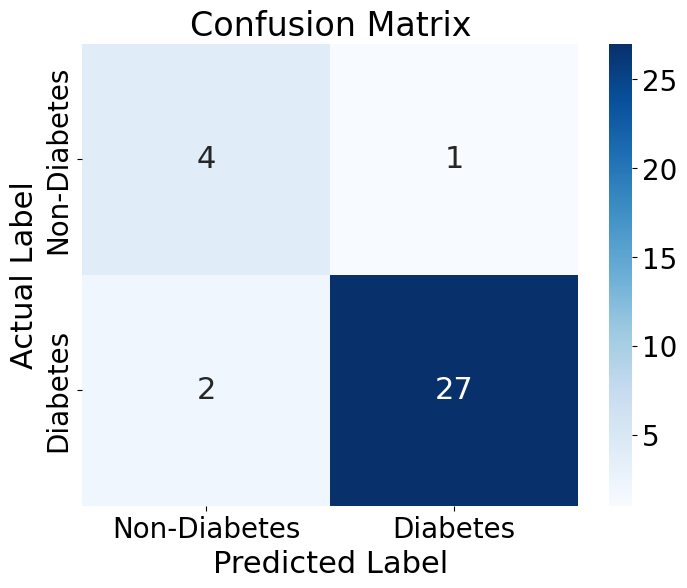

ROC AUC: 0.9586


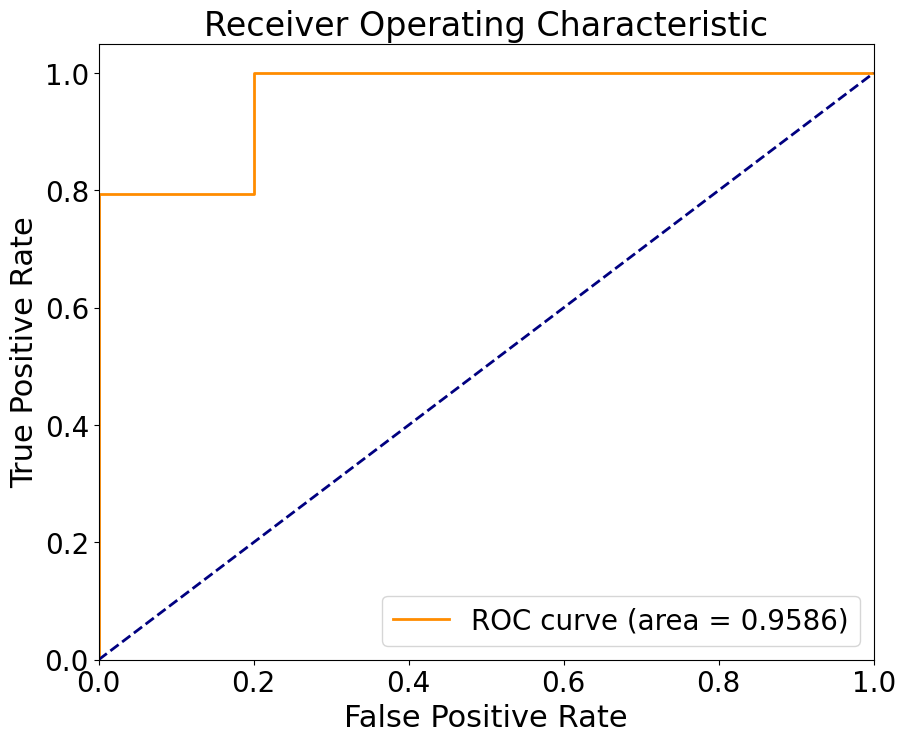

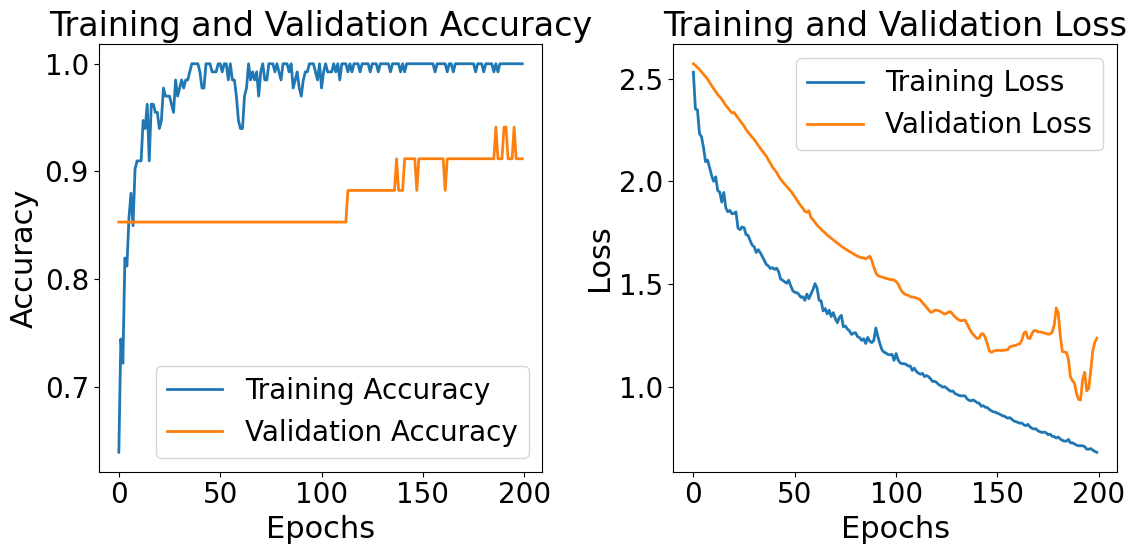

In [17]:
evaluate_model(model, X_train_termogram_left, X_train_termogram_right, X_train_tabular, 
               y_train, X_test_termogram_left, X_test_termogram_right, X_test_tabular, y_test, history)

In [19]:
model_name = "Model/model3_ori_200.h5"
model_path = save_model(model, model_name)

Model saved as Model/model3_ori_200.h5


In [20]:
accuracies, precisions, recalls, f1_scores, aucs = k_fold_cross_validation(
    create_model_for_kfold, 
    termograms_left, 
    termograms_right, 
    tabular_data, 
    labels, 
)

Results for fold 1
2/2 [==============================] - 0s 19ms/step
Fold 1 Accuracy: 0.8529
Fold 1 Precision: 0.8667
Fold 1 Recall: 0.9630
Fold 1 F1-score: 0.9123
Fold 1 ROC AUC: 0.9048

Results for fold 2
2/2 [==============================] - 0s 21ms/step
Fold 2 Accuracy: 0.8824
Fold 2 Precision: 0.9231
Fold 2 Recall: 0.9231
Fold 2 F1-score: 0.9231
Fold 2 ROC AUC: 0.9423

Results for fold 3
2/2 [==============================] - 0s 366ms/step
Fold 3 Accuracy: 0.8788
Fold 3 Precision: 0.9130
Fold 3 Recall: 0.9130
Fold 3 F1-score: 0.9130
Fold 3 ROC AUC: 0.9565

Results for fold 4
2/2 [==============================] - 0s 19ms/step
Fold 4 Accuracy: 0.8788
Fold 4 Precision: 0.8462
Fold 4 Recall: 1.0000
Fold 4 F1-score: 0.9167
Fold 4 ROC AUC: 0.9215

Results for fold 5
2/2 [==============================] - 0s 3ms/step
Fold 5 Accuracy: 0.8485
Fold 5 Precision: 0.9130
Fold 5 Recall: 0.8750
Fold 5 F1-score: 0.8936
Fold 5 ROC AUC: 0.9630

Mean Accuracy: 0.8683
Mean Precision: 0.8924
Mean 

## Posterize 8 colors

In [18]:
img_dir_post_8 = 'Image enhancement\ehnancement new\image posterized (8 colors)'
history, model,\
    termograms_left, termograms_right, tabular_data, labels,\
    X_train_termogram_left, X_test_termogram_left,\
    X_train_termogram_right, X_test_termogram_right,\
    X_train_tabular, X_test_tabular,\
    y_train, y_test = run_experiment(img_dir_post_8)

Ukuran train dan test data termogram kaki kiri: ((133, 64, 149, 3), (34, 64, 149, 3))
Ukuran train dan test data termogram kaki kanan: ((133, 64, 149, 3), (34, 64, 149, 3))
Ukuran train dan test data tabular: ((133, 13), (34, 13))
Ukuran label: ((133,), (34,))
Training time: 74.83950877189636 seconds


### Result

Test Loss: 0.9842959046363831, Test Accuracy: 0.8529411554336548
Train Loss: 0.6327764987945557, Train Accuracy: 1.0
2/2 [==============================] - 0s 18ms/step
Inference time for one sample: 0.19457268714904785 seconds
Accuracy: 0.8529
Precision: 0.9286
Recall: 0.8966
F1-score: 0.9123
Confusion Matrix:
[[ 3  2]
 [ 3 26]]


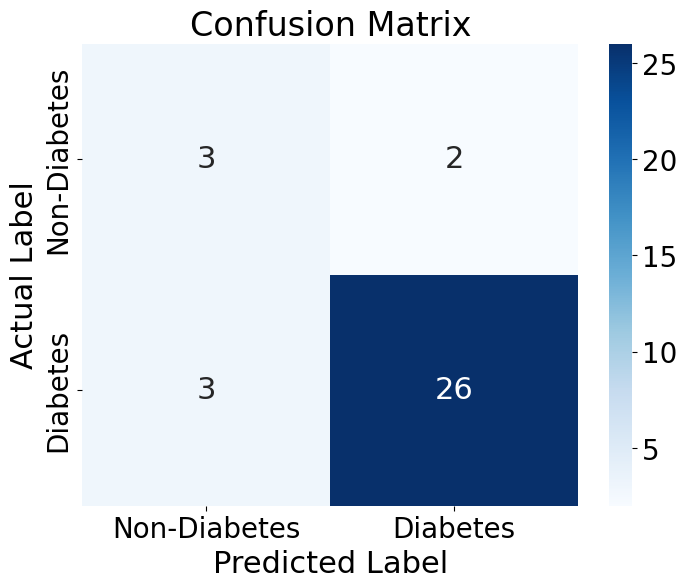

ROC AUC: 0.9310


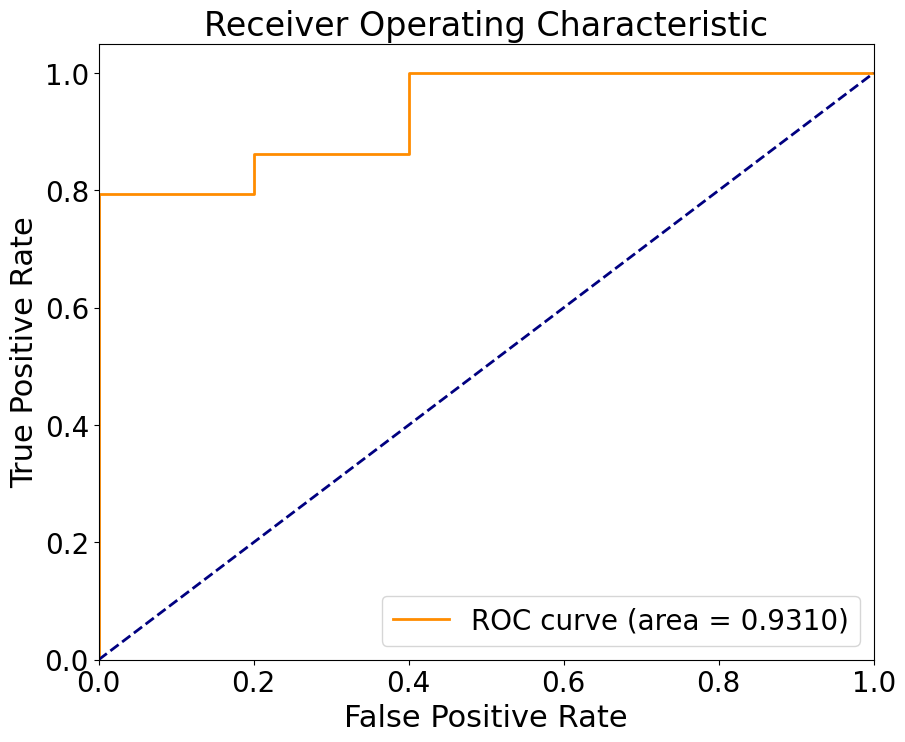

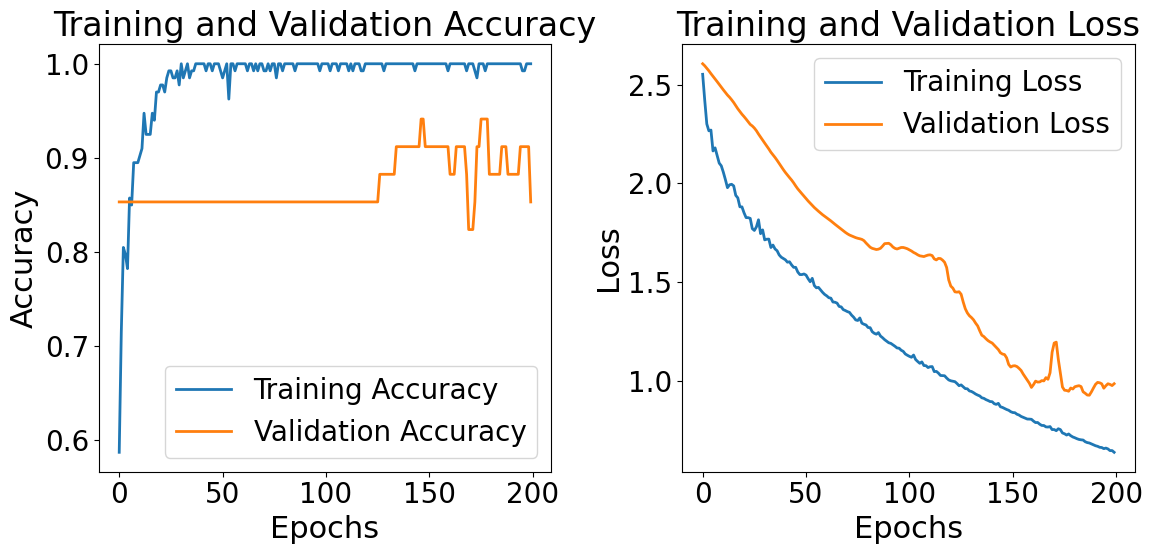

In [19]:
evaluate_model(model, X_train_termogram_left, X_train_termogram_right, X_train_tabular, 
               y_train, X_test_termogram_left, X_test_termogram_right, X_test_tabular, y_test, history)

In [23]:
model_name = "Model/model3_post_8_200.h5"
model_path = save_model(model, model_name)

Model saved as Model/model3_post_8_200.h5


In [24]:
accuracies, precisions, recalls, f1_scores, aucs = k_fold_cross_validation(
    create_model_for_kfold, 
    termograms_left, 
    termograms_right, 
    tabular_data, 
    labels, 
)

Results for fold 1
2/2 [==============================] - 0s 13ms/step
Fold 1 Accuracy: 0.7941
Fold 1 Precision: 0.9167
Fold 1 Recall: 0.8148
Fold 1 F1-score: 0.8627
Fold 1 ROC AUC: 0.8783

Results for fold 2
2/2 [==============================] - 0s 18ms/step
Fold 2 Accuracy: 0.8529
Fold 2 Precision: 0.9565
Fold 2 Recall: 0.8462
Fold 2 F1-score: 0.8980
Fold 2 ROC AUC: 0.9183

Results for fold 3
2/2 [==============================] - 0s 20ms/step
Fold 3 Accuracy: 0.7273
Fold 3 Precision: 0.7917
Fold 3 Recall: 0.8261
Fold 3 F1-score: 0.8085
Fold 3 ROC AUC: 0.8957

Results for fold 4
2/2 [==============================] - 0s 19ms/step
Fold 4 Accuracy: 0.8485
Fold 4 Precision: 0.8400
Fold 4 Recall: 0.9545
Fold 4 F1-score: 0.8936
Fold 4 ROC AUC: 0.8760

Results for fold 5
2/2 [==============================] - 0s 20ms/step
Fold 5 Accuracy: 0.8182
Fold 5 Precision: 1.0000
Fold 5 Recall: 0.7500
Fold 5 F1-score: 0.8571
Fold 5 ROC AUC: 0.8981

Mean Accuracy: 0.8082
Mean Precision: 0.9010
Mean 

## Posterize 64 colors

In [20]:
img_dir_post_64 = 'Image enhancement\ehnancement new\image posterized (64 colors)'
history, model,\
    termograms_left, termograms_right, tabular_data, labels,\
    X_train_termogram_left, X_test_termogram_left,\
    X_train_termogram_right, X_test_termogram_right,\
    X_train_tabular, X_test_tabular,\
    y_train, y_test = run_experiment(img_dir_post_64)

Ukuran train dan test data termogram kaki kiri: ((133, 64, 149, 3), (34, 64, 149, 3))
Ukuran train dan test data termogram kaki kanan: ((133, 64, 149, 3), (34, 64, 149, 3))
Ukuran train dan test data tabular: ((133, 13), (34, 13))
Ukuran label: ((133,), (34,))
Training time: 76.63234281539917 seconds


### Result

Test Loss: 1.370386004447937, Test Accuracy: 0.9117646813392639
Train Loss: 0.8066600561141968, Train Accuracy: 1.0
2/2 [==============================] - 0s 2ms/step
Inference time for one sample: 0.20023870468139648 seconds
Accuracy: 0.9118
Precision: 0.9643
Recall: 0.9310
F1-score: 0.9474
Confusion Matrix:
[[ 4  1]
 [ 2 27]]


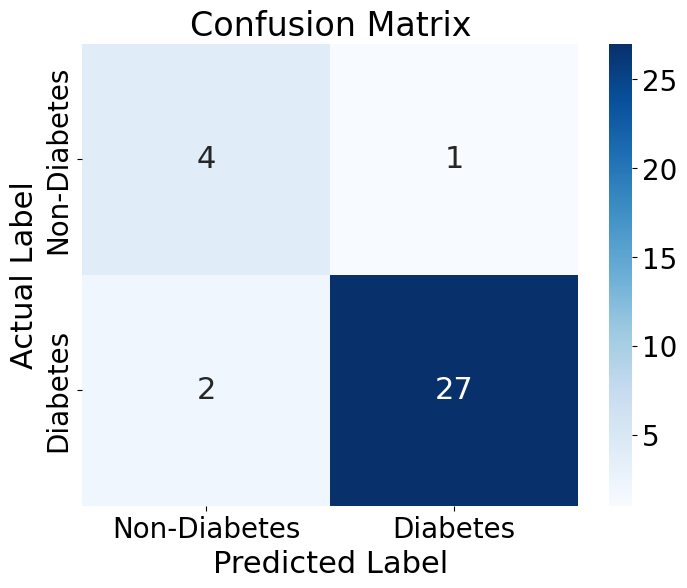

ROC AUC: 0.9172


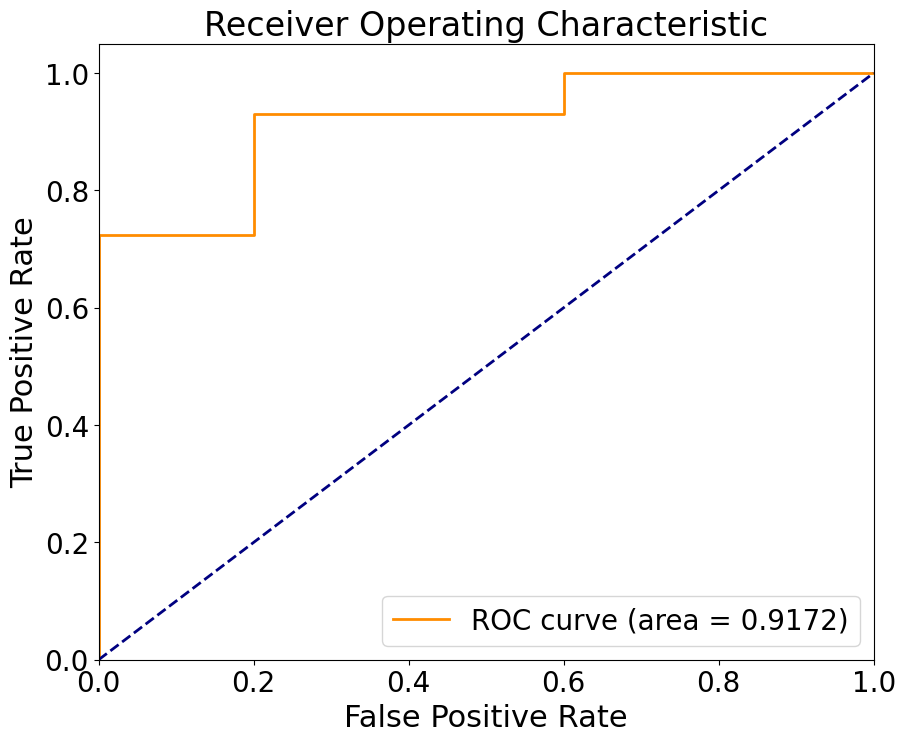

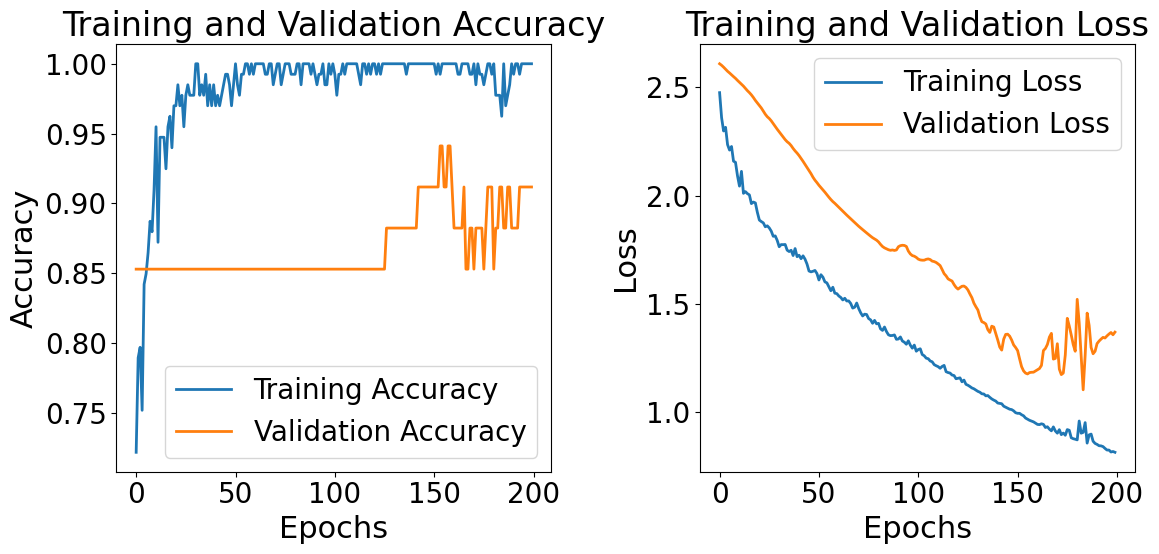

In [21]:
evaluate_model(model, X_train_termogram_left, X_train_termogram_right, X_train_tabular, 
               y_train, X_test_termogram_left, X_test_termogram_right, X_test_tabular, y_test, history)

In [27]:
model_name = "Model/model3_post_64_200.h5"
model_path = save_model(model, model_name)

Model saved as Model/model3_post_64_200.h5


In [28]:
accuracies, precisions, recalls, f1_scores, aucs = k_fold_cross_validation(
    create_model_for_kfold, 
    termograms_left, 
    termograms_right, 
    tabular_data, 
    labels, 
)

Results for fold 1
2/2 [==============================] - 0s 19ms/step
Fold 1 Accuracy: 0.8235
Fold 1 Precision: 0.8889
Fold 1 Recall: 0.8889
Fold 1 F1-score: 0.8889
Fold 1 ROC AUC: 0.9153

Results for fold 2
2/2 [==============================] - 0s 18ms/step
Fold 2 Accuracy: 0.9118
Fold 2 Precision: 0.9600
Fold 2 Recall: 0.9231
Fold 2 F1-score: 0.9412
Fold 2 ROC AUC: 0.9279

Results for fold 3
2/2 [==============================] - 0s 20ms/step
Fold 3 Accuracy: 0.9091
Fold 3 Precision: 0.9545
Fold 3 Recall: 0.9130
Fold 3 F1-score: 0.9333
Fold 3 ROC AUC: 0.9348

Results for fold 4
2/2 [==============================] - 0s 19ms/step
Fold 4 Accuracy: 0.7879
Fold 4 Precision: 0.8261
Fold 4 Recall: 0.8636
Fold 4 F1-score: 0.8444
Fold 4 ROC AUC: 0.9008

Results for fold 5
2/2 [==============================] - 0s 19ms/step
Fold 5 Accuracy: 0.8788
Fold 5 Precision: 0.9545
Fold 5 Recall: 0.8750
Fold 5 F1-score: 0.9130
Fold 5 ROC AUC: 0.9352

Mean Accuracy: 0.8622
Mean Precision: 0.9168
Mean 

## Solarize

In [22]:
img_dir_slr = 'Image enhancement\ehnancement new\image solarized'
history, model,\
    termograms_left, termograms_right, tabular_data, labels,\
    X_train_termogram_left, X_test_termogram_left,\
    X_train_termogram_right, X_test_termogram_right,\
    X_train_tabular, X_test_tabular,\
    y_train, y_test = run_experiment(img_dir_slr)

Ukuran train dan test data termogram kaki kiri: ((133, 64, 149, 3), (34, 64, 149, 3))
Ukuran train dan test data termogram kaki kanan: ((133, 64, 149, 3), (34, 64, 149, 3))
Ukuran train dan test data tabular: ((133, 13), (34, 13))
Ukuran label: ((133,), (34,))
Training time: 78.4274971485138 seconds


### Result

Test Loss: 0.9249453544616699, Test Accuracy: 0.9411764740943909
Train Loss: 0.6557523608207703, Train Accuracy: 1.0
2/2 [==============================] - 0s 19ms/step
Inference time for one sample: 0.20624899864196777 seconds
Accuracy: 0.9412
Precision: 0.9655
Recall: 0.9655
F1-score: 0.9655
Confusion Matrix:
[[ 4  1]
 [ 1 28]]


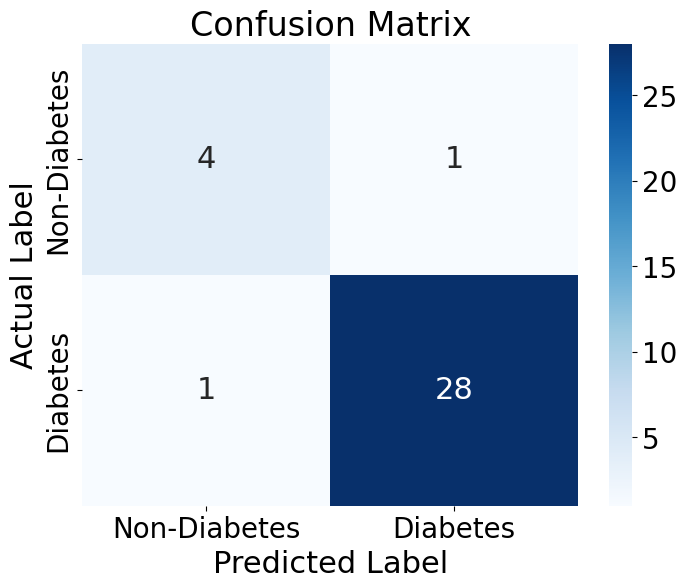

ROC AUC: 0.9448


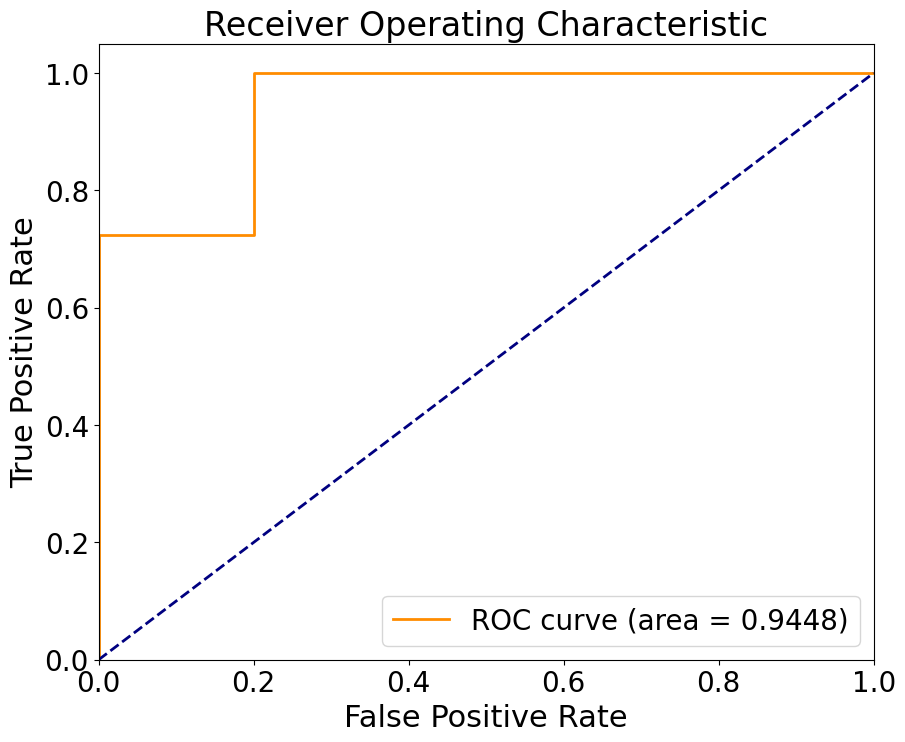

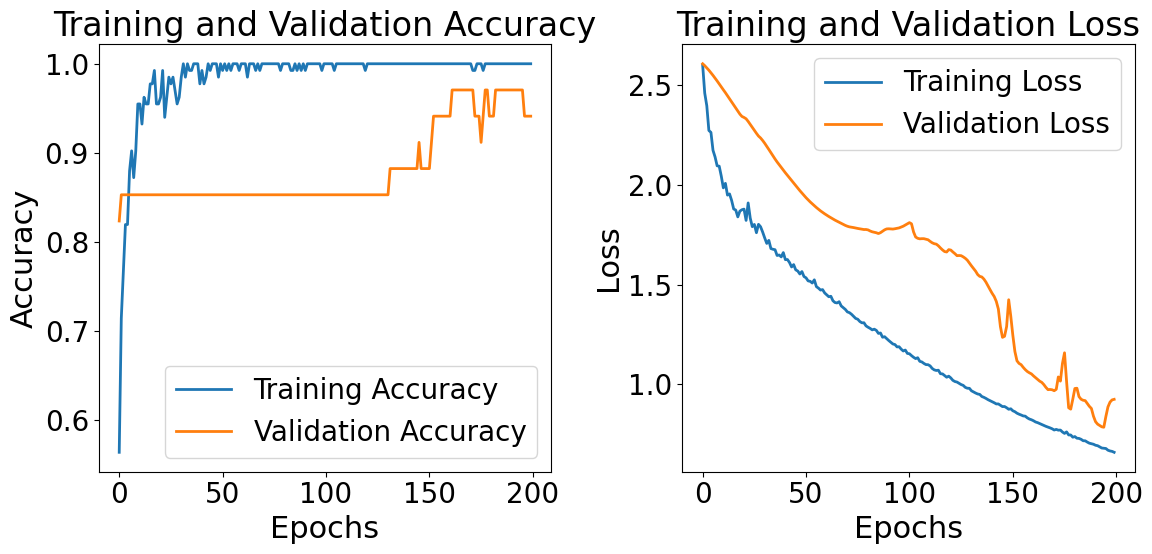

In [23]:
evaluate_model(model, X_train_termogram_left, X_train_termogram_right, X_train_tabular, 
               y_train, X_test_termogram_left, X_test_termogram_right, X_test_tabular, y_test, history)

In [31]:
model_name = "Model/model3_slr_200.h5"
model_path = save_model(model, model_name)

Model saved as Model/model3_slr_200.h5


In [32]:
accuracies, precisions, recalls, f1_scores, aucs = k_fold_cross_validation(
    create_model_for_kfold, 
    termograms_left, 
    termograms_right, 
    tabular_data, 
    labels, 
)

Results for fold 1
2/2 [==============================] - 0s 19ms/step
Fold 1 Accuracy: 0.8235
Fold 1 Precision: 0.8889
Fold 1 Recall: 0.8889
Fold 1 F1-score: 0.8889
Fold 1 ROC AUC: 0.8466

Results for fold 2
2/2 [==============================] - 0s 17ms/step
Fold 2 Accuracy: 0.8235
Fold 2 Precision: 0.8846
Fold 2 Recall: 0.8846
Fold 2 F1-score: 0.8846
Fold 2 ROC AUC: 0.9183

Results for fold 3
2/2 [==============================] - 0s 6ms/step
Fold 3 Accuracy: 0.9091
Fold 3 Precision: 0.9545
Fold 3 Recall: 0.9130
Fold 3 F1-score: 0.9333
Fold 3 ROC AUC: 0.9870

Results for fold 4
2/2 [==============================] - 0s 18ms/step
Fold 4 Accuracy: 0.9394
Fold 4 Precision: 0.9545
Fold 4 Recall: 0.9545
Fold 4 F1-score: 0.9545
Fold 4 ROC AUC: 0.9835

Results for fold 5
2/2 [==============================] - 0s 13ms/step
Fold 5 Accuracy: 0.9091
Fold 5 Precision: 0.9565
Fold 5 Recall: 0.9167
Fold 5 F1-score: 0.9362
Fold 5 ROC AUC: 0.9815

Mean Accuracy: 0.8809
Mean Precision: 0.9278
Mean R

## CLAHE

In [24]:
img_dir_clahe = 'Image enhancement\ehnancement new\image CLAHE'
history, model,\
    termograms_left, termograms_right, tabular_data, labels,\
    X_train_termogram_left, X_test_termogram_left,\
    X_train_termogram_right, X_test_termogram_right,\
    X_train_tabular, X_test_tabular,\
    y_train, y_test = run_experiment(img_dir_clahe)

Ukuran train dan test data termogram kaki kiri: ((133, 64, 149, 3), (34, 64, 149, 3))
Ukuran train dan test data termogram kaki kanan: ((133, 64, 149, 3), (34, 64, 149, 3))
Ukuran train dan test data tabular: ((133, 13), (34, 13))
Ukuran label: ((133,), (34,))
Training time: 77.8227846622467 seconds


### Result

Test Loss: 0.9268583059310913, Test Accuracy: 0.9117646813392639
Train Loss: 0.7328475117683411, Train Accuracy: 1.0
2/2 [==============================] - 0s 17ms/step
Inference time for one sample: 0.23373198509216309 seconds
Accuracy: 0.9118
Precision: 1.0000
Recall: 0.8966
F1-score: 0.9455
Confusion Matrix:
[[ 5  0]
 [ 3 26]]


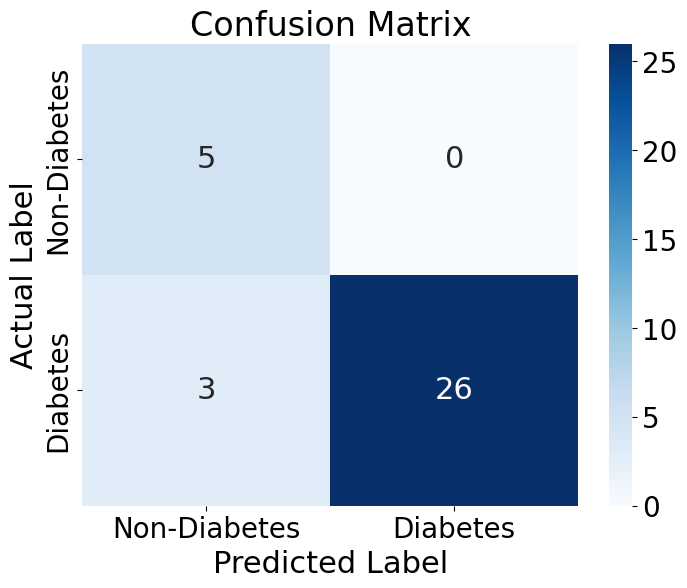

ROC AUC: 0.9862


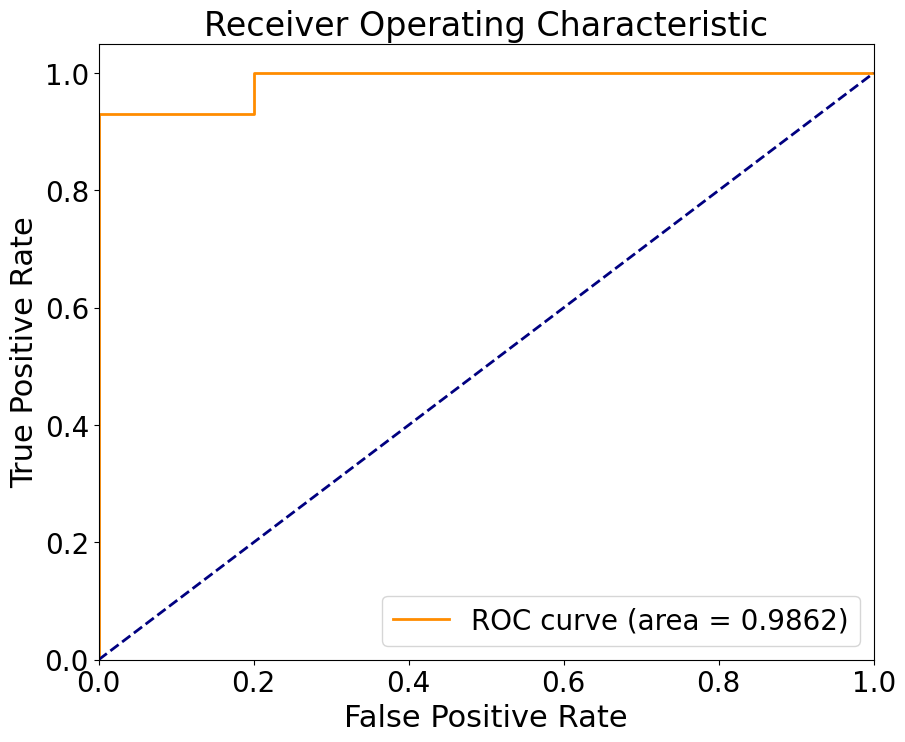

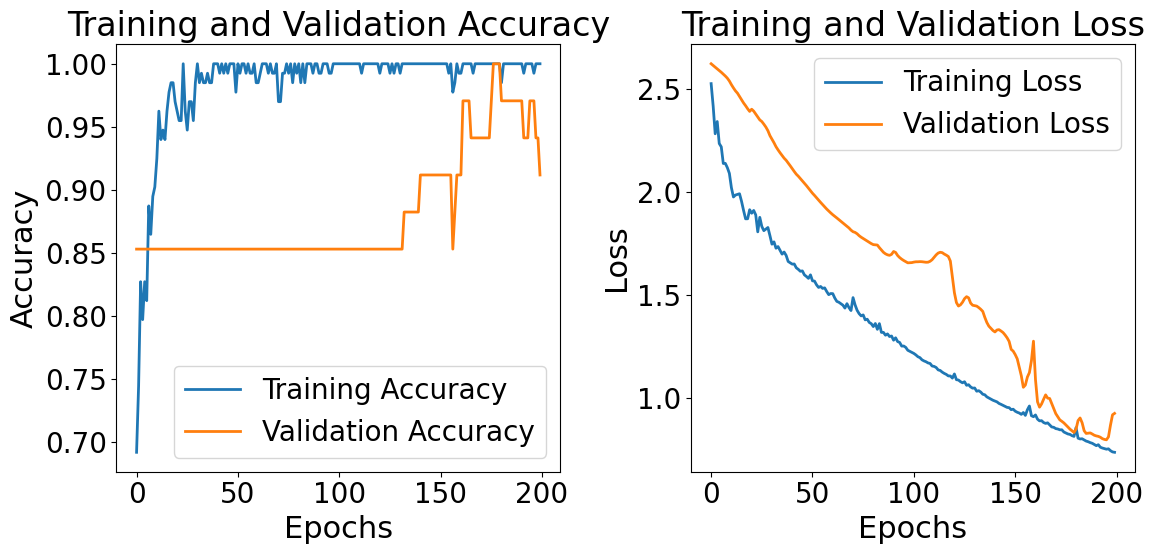

In [25]:
evaluate_model(model, X_train_termogram_left, X_train_termogram_right, X_train_tabular, 
               y_train, X_test_termogram_left, X_test_termogram_right, X_test_tabular, y_test, history)

In [35]:
model_name = "Model/model3_slr_200.h5"
model_path = save_model(model, model_name)

Model saved as Model/model3_slr_200.h5


In [36]:
accuracies, precisions, recalls, f1_scores, aucs = k_fold_cross_validation(
    create_model_for_kfold, 
    termograms_left, 
    termograms_right, 
    tabular_data, 
    labels
)

Results for fold 1
2/2 [==============================] - 0s 4ms/step
Fold 1 Accuracy: 0.8824
Fold 1 Precision: 0.9259
Fold 1 Recall: 0.9259
Fold 1 F1-score: 0.9259
Fold 1 ROC AUC: 0.9683

Results for fold 2
2/2 [==============================] - 0s 19ms/step
Fold 2 Accuracy: 0.9118
Fold 2 Precision: 0.9259
Fold 2 Recall: 0.9615
Fold 2 F1-score: 0.9434
Fold 2 ROC AUC: 0.9423

Results for fold 3
2/2 [==============================] - 0s 13ms/step
Fold 3 Accuracy: 0.8788
Fold 3 Precision: 0.9524
Fold 3 Recall: 0.8696
Fold 3 F1-score: 0.9091
Fold 3 ROC AUC: 0.9435

Results for fold 4
2/2 [==============================] - 0s 20ms/step
Fold 4 Accuracy: 0.8788
Fold 4 Precision: 0.8462
Fold 4 Recall: 1.0000
Fold 4 F1-score: 0.9167
Fold 4 ROC AUC: 0.9298

Results for fold 5
2/2 [==============================] - 0s 20ms/step
Fold 5 Accuracy: 0.9091
Fold 5 Precision: 0.9200
Fold 5 Recall: 0.9583
Fold 5 F1-score: 0.9388
Fold 5 ROC AUC: 0.9537

Mean Accuracy: 0.8922
Mean Precision: 0.9141
Mean R

## Gamma adjusted

In [26]:
img_dir_gamma = 'Image enhancement\ehnancement new\image gamma adjusted'
history, model,\
    termograms_left, termograms_right, tabular_data, labels,\
    X_train_termogram_left, X_test_termogram_left,\
    X_train_termogram_right, X_test_termogram_right,\
    X_train_tabular, X_test_tabular,\
    y_train, y_test = run_experiment(img_dir_gamma)

Ukuran train dan test data termogram kaki kiri: ((133, 64, 149, 3), (34, 64, 149, 3))
Ukuran train dan test data termogram kaki kanan: ((133, 64, 149, 3), (34, 64, 149, 3))
Ukuran train dan test data tabular: ((133, 13), (34, 13))
Ukuran label: ((133,), (34,))
Training time: 78.58204889297485 seconds


### Result

Test Loss: 1.2753610610961914, Test Accuracy: 0.9117646813392639
Train Loss: 0.8328776359558105, Train Accuracy: 1.0
2/2 [==============================] - 0s 19ms/step
Inference time for one sample: 0.23118925094604492 seconds
Accuracy: 0.9118
Precision: 0.9643
Recall: 0.9310
F1-score: 0.9474
Confusion Matrix:
[[ 4  1]
 [ 2 27]]


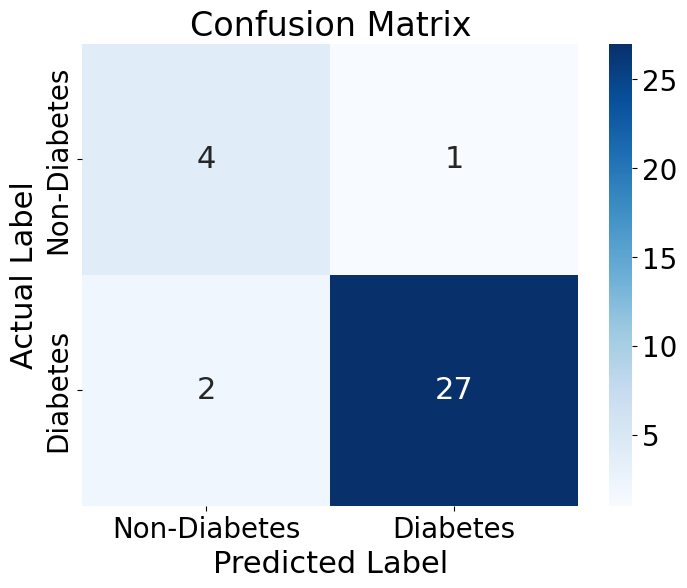

ROC AUC: 0.9448


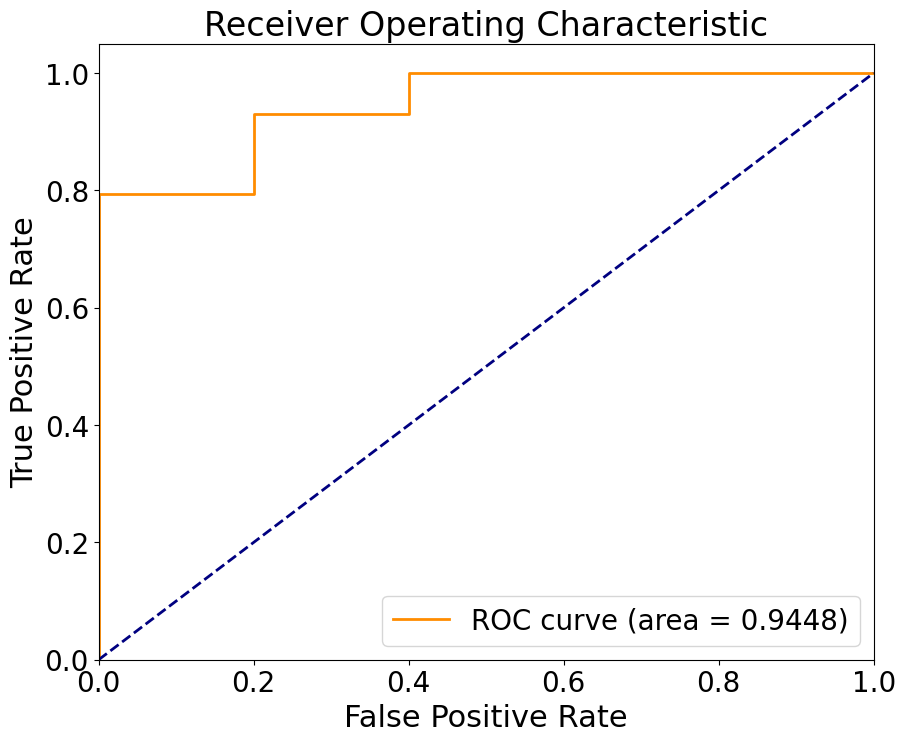

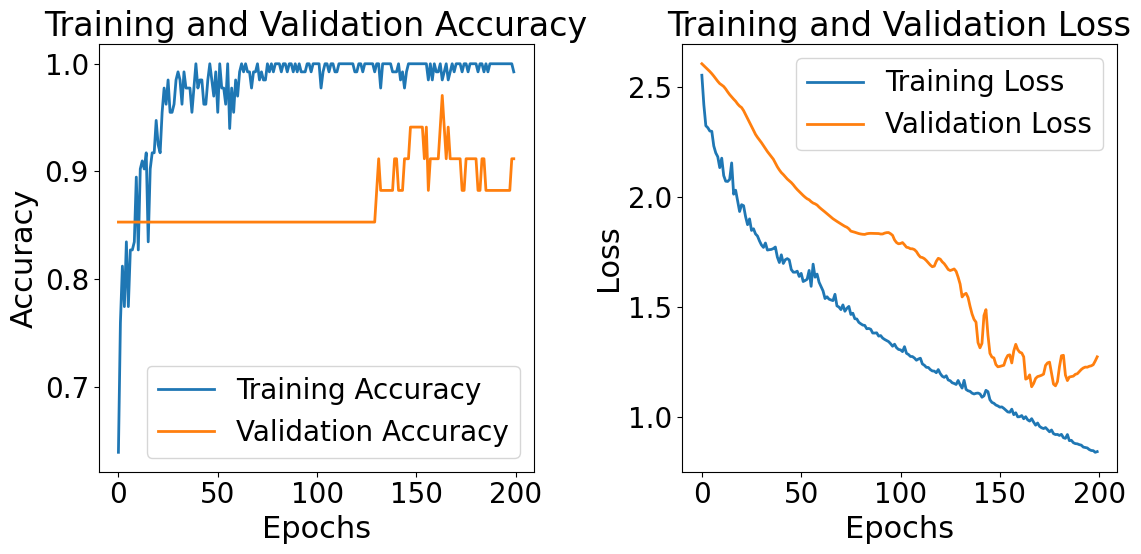

In [27]:
evaluate_model(model, X_train_termogram_left, X_train_termogram_right, X_train_tabular, 
               y_train, X_test_termogram_left, X_test_termogram_right, X_test_tabular, y_test, history)

In [17]:
model_name = "Model/model2_gamma_200.h5"
model_path = save_model(model, model_name)

Model saved as Model/model2_gamma_200.h5


In [18]:
accuracies, precisions, recalls, f1_scores, aucs = k_fold_cross_validation(
    create_model_for_kfold, 
    termograms_left, 
    termograms_right, 
    tabular_data, 
    labels, 
)

Results for fold 1
2/2 [==============================] - 0s 18ms/step
Fold 1 Accuracy: 0.8529
Fold 1 Precision: 0.8929
Fold 1 Recall: 0.9259
Fold 1 F1-score: 0.9091
Fold 1 ROC AUC: 0.8942

Results for fold 2
2/2 [==============================] - 0s 18ms/step
Fold 2 Accuracy: 0.8824
Fold 2 Precision: 0.8929
Fold 2 Recall: 0.9615
Fold 2 F1-score: 0.9259
Fold 2 ROC AUC: 0.9279

Results for fold 3
2/2 [==============================] - 0s 345ms/step
Fold 3 Accuracy: 0.9091
Fold 3 Precision: 0.9545
Fold 3 Recall: 0.9130
Fold 3 F1-score: 0.9333
Fold 3 ROC AUC: 0.9652

Results for fold 4
2/2 [==============================] - 0s 16ms/step
Fold 4 Accuracy: 0.8788
Fold 4 Precision: 0.8462
Fold 4 Recall: 1.0000
Fold 4 F1-score: 0.9167
Fold 4 ROC AUC: 0.9421

Results for fold 5
2/2 [==============================] - 0s 18ms/step
Fold 5 Accuracy: 0.8788
Fold 5 Precision: 0.9545
Fold 5 Recall: 0.8750
Fold 5 F1-score: 0.9130
Fold 5 ROC AUC: 0.9630

Mean Accuracy: 0.8804
Mean Precision: 0.9082
Mean

# Modeling for Model 2 with 500 epochs

## Original data

In [28]:
img_dir_ori = 'Image enhancement\images resized'
history, model,\
    termograms_left, termograms_right, tabular_data, labels,\
    X_train_termogram_left, X_test_termogram_left,\
    X_train_termogram_right, X_test_termogram_right,\
    X_train_tabular, X_test_tabular,\
    y_train, y_test = run_experiment(img_dir_ori, epochs=500)

Ukuran train dan test data termogram kaki kiri: ((133, 64, 149, 3), (34, 64, 149, 3))
Ukuran train dan test data termogram kaki kanan: ((133, 64, 149, 3), (34, 64, 149, 3))
Ukuran train dan test data tabular: ((133, 13), (34, 13))
Ukuran label: ((133,), (34,))
Training time: 190.20289659500122 seconds


### Result

Test Loss: 0.3625050187110901, Test Accuracy: 0.9411764740943909
Train Loss: 0.17678391933441162, Train Accuracy: 1.0
2/2 [==============================] - 0s 20ms/step
Inference time for one sample: 0.22207021713256836 seconds
Accuracy: 0.9412
Precision: 1.0000
Recall: 0.9310
F1-score: 0.9643
Confusion Matrix:
[[ 5  0]
 [ 2 27]]


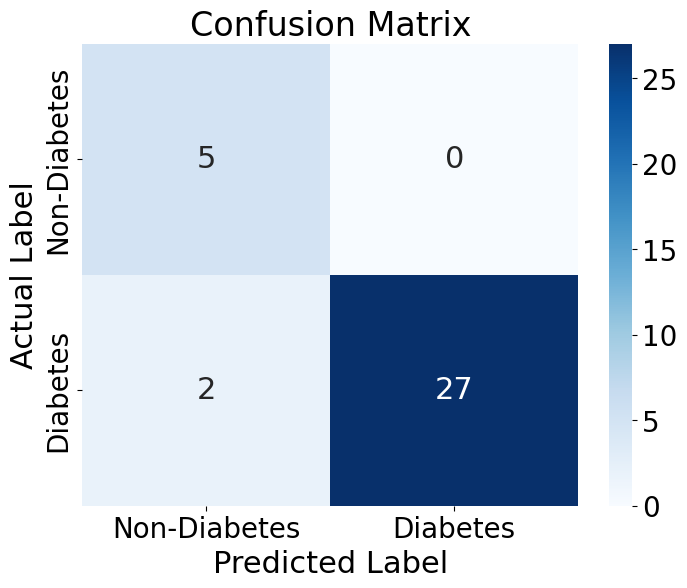

ROC AUC: 0.9793


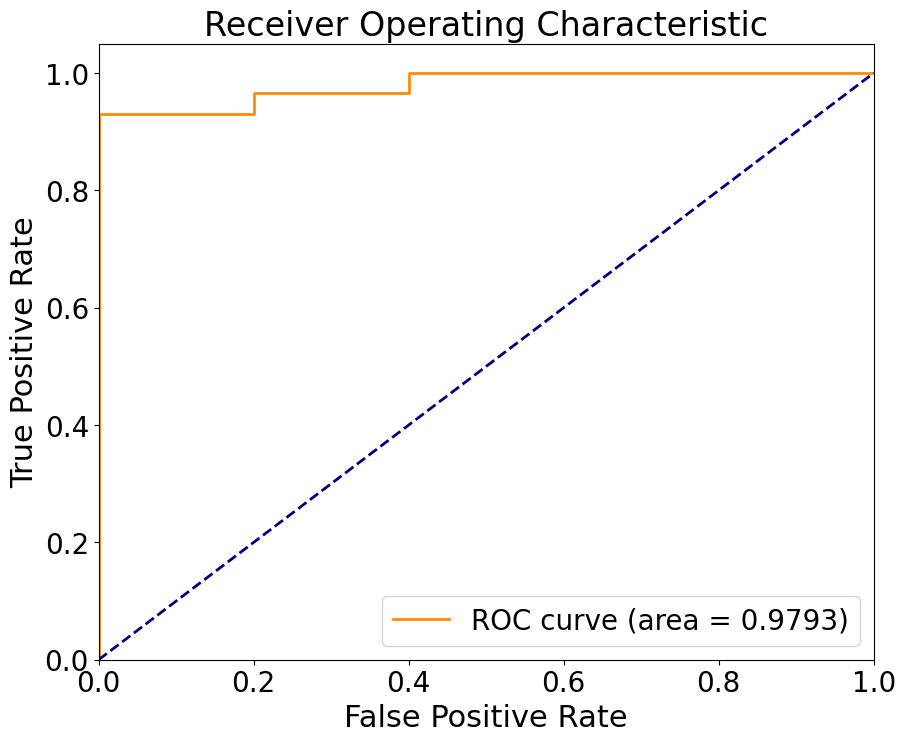

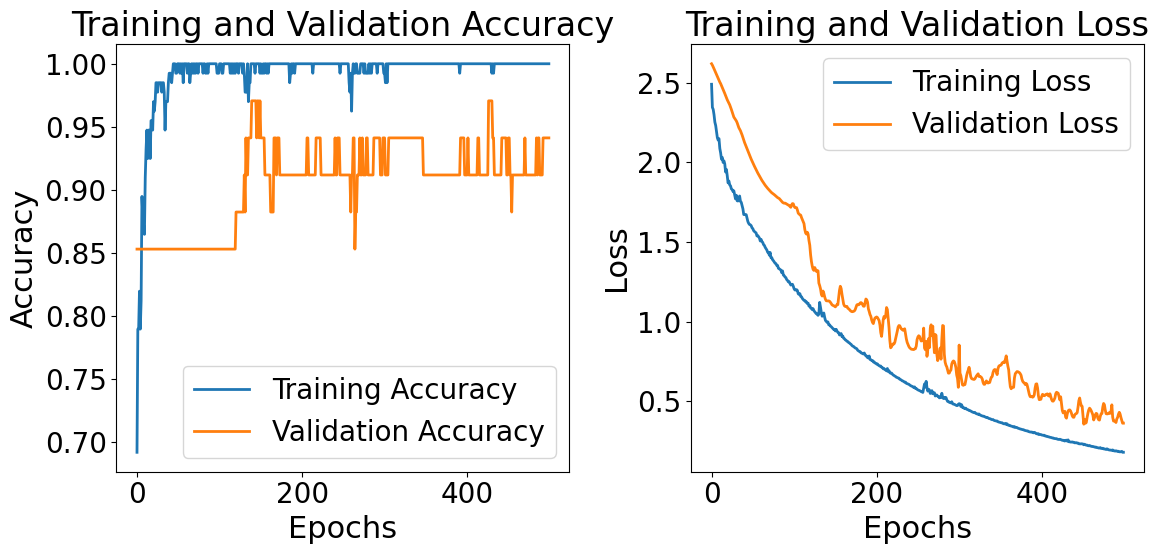

In [29]:
evaluate_model(model, X_train_termogram_left, X_train_termogram_right, X_train_tabular, 
               y_train, X_test_termogram_left, X_test_termogram_right, X_test_tabular, y_test, history)

In [39]:
model_name = "Model/model3_ori_500.h5"
model_path = save_model(model, model_name)

Model saved as Model/model3_ori_500.h5


In [40]:
accuracies, precisions, recalls, f1_scores, aucs = k_fold_cross_validation(
    create_model_for_kfold, 
    termograms_left, 
    termograms_right, 
    tabular_data, 
    labels,
    epochs=500
)

Results for fold 1
2/2 [==============================] - 0s 20ms/step
Fold 1 Accuracy: 0.8824
Fold 1 Precision: 0.8966
Fold 1 Recall: 0.9630
Fold 1 F1-score: 0.9286
Fold 1 ROC AUC: 0.8942

Results for fold 2
2/2 [==============================] - 0s 10ms/step
Fold 2 Accuracy: 0.8824
Fold 2 Precision: 0.9231
Fold 2 Recall: 0.9231
Fold 2 F1-score: 0.9231
Fold 2 ROC AUC: 0.9519

Results for fold 3
2/2 [==============================] - 0s 3ms/step
Fold 3 Accuracy: 0.8788
Fold 3 Precision: 0.9130
Fold 3 Recall: 0.9130
Fold 3 F1-score: 0.9130
Fold 3 ROC AUC: 0.9348

Results for fold 4
2/2 [==============================] - 0s 21ms/step
Fold 4 Accuracy: 0.8788
Fold 4 Precision: 0.8462
Fold 4 Recall: 1.0000
Fold 4 F1-score: 0.9167
Fold 4 ROC AUC: 0.9256

Results for fold 5
2/2 [==============================] - 0s 18ms/step
Fold 5 Accuracy: 0.9091
Fold 5 Precision: 1.0000
Fold 5 Recall: 0.8750
Fold 5 F1-score: 0.9333
Fold 5 ROC AUC: 0.9630

Mean Accuracy: 0.8863
Mean Precision: 0.9158
Mean R

## Posterize 8 colors

In [30]:
img_dir_post_8 = 'Image enhancement\ehnancement new\image posterized (8 colors)'
history, model,\
    termograms_left, termograms_right, tabular_data, labels,\
    X_train_termogram_left, X_test_termogram_left,\
    X_train_termogram_right, X_test_termogram_right,\
    X_train_tabular, X_test_tabular,\
    y_train, y_test = run_experiment(img_dir_post_8, epochs=500)

Ukuran train dan test data termogram kaki kiri: ((133, 64, 149, 3), (34, 64, 149, 3))
Ukuran train dan test data termogram kaki kanan: ((133, 64, 149, 3), (34, 64, 149, 3))
Ukuran train dan test data tabular: ((133, 13), (34, 13))
Ukuran label: ((133,), (34,))
Training time: 188.01522779464722 seconds


### Result

Test Loss: 0.49413421750068665, Test Accuracy: 0.9411764740943909
Train Loss: 0.17495040595531464, Train Accuracy: 1.0
2/2 [==============================] - 0s 17ms/step
Inference time for one sample: 0.20084285736083984 seconds
Accuracy: 0.9412
Precision: 0.9655
Recall: 0.9655
F1-score: 0.9655
Confusion Matrix:
[[ 4  1]
 [ 1 28]]


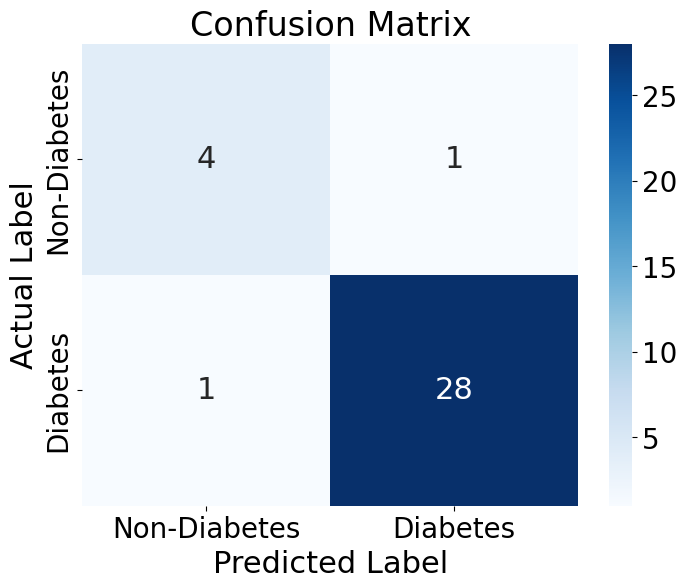

ROC AUC: 0.9586


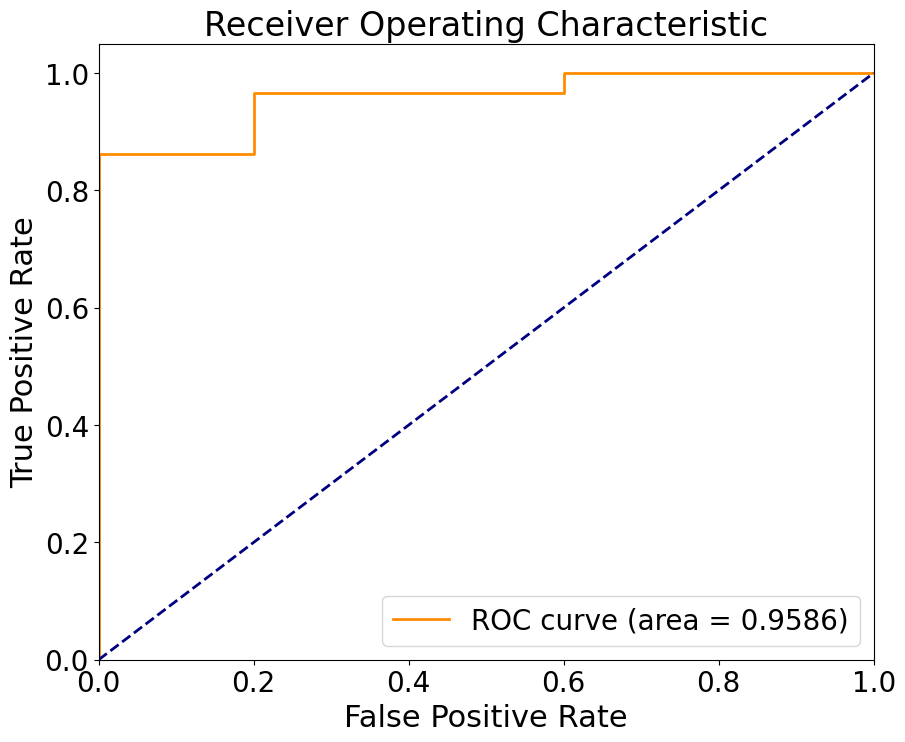

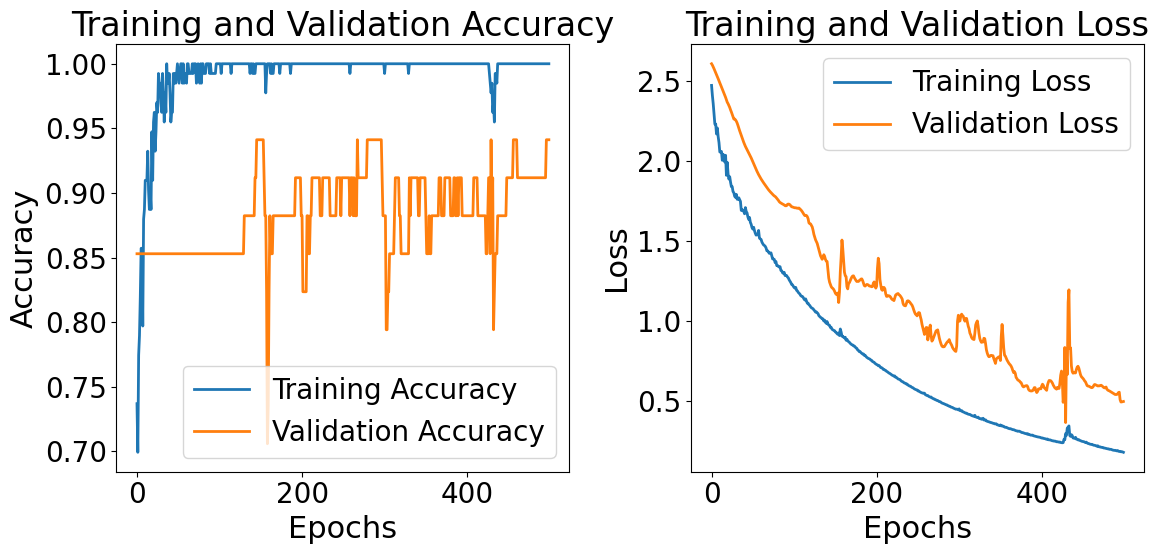

In [31]:
evaluate_model(model, X_train_termogram_left, X_train_termogram_right, X_train_tabular, 
               y_train, X_test_termogram_left, X_test_termogram_right, X_test_tabular, y_test, history)

In [43]:
model_name = "Model/model3_post_8_500.h5"
model_path = save_model(model, model_name)

Model saved as Model/model3_post_8_500.h5


In [44]:
accuracies, precisions, recalls, f1_scores, aucs = k_fold_cross_validation(
    create_model_for_kfold, 
    termograms_left, 
    termograms_right, 
    tabular_data, 
    labels,
    epochs=500
)

Results for fold 1
2/2 [==============================] - 0s 21ms/step
Fold 1 Accuracy: 0.7647
Fold 1 Precision: 0.8800
Fold 1 Recall: 0.8148
Fold 1 F1-score: 0.8462
Fold 1 ROC AUC: 0.8730

Results for fold 2
2/2 [==============================] - 0s 18ms/step
Fold 2 Accuracy: 0.8824
Fold 2 Precision: 0.9583
Fold 2 Recall: 0.8846
Fold 2 F1-score: 0.9200
Fold 2 ROC AUC: 0.9183

Results for fold 3
2/2 [==============================] - 0s 17ms/step
Fold 3 Accuracy: 0.7576
Fold 3 Precision: 0.8000
Fold 3 Recall: 0.8696
Fold 3 F1-score: 0.8333
Fold 3 ROC AUC: 0.9087

Results for fold 4
2/2 [==============================] - 0s 19ms/step
Fold 4 Accuracy: 0.7879
Fold 4 Precision: 0.8261
Fold 4 Recall: 0.8636
Fold 4 F1-score: 0.8444
Fold 4 ROC AUC: 0.9256

Results for fold 5
2/2 [==============================] - 0s 18ms/step
Fold 5 Accuracy: 0.8788
Fold 5 Precision: 0.9545
Fold 5 Recall: 0.8750
Fold 5 F1-score: 0.9130
Fold 5 ROC AUC: 0.9259

Mean Accuracy: 0.8143
Mean Precision: 0.8838
Mean 

## Posterize 64 colors

In [32]:
img_dir_post_64 = 'Image enhancement\ehnancement new\image posterized (64 colors)'
history, model,\
    termograms_left, termograms_right, tabular_data, labels,\
    X_train_termogram_left, X_test_termogram_left,\
    X_train_termogram_right, X_test_termogram_right,\
    X_train_tabular, X_test_tabular,\
    y_train, y_test = run_experiment(img_dir_post_64, epochs=500)

Ukuran train dan test data termogram kaki kiri: ((133, 64, 149, 3), (34, 64, 149, 3))
Ukuran train dan test data termogram kaki kanan: ((133, 64, 149, 3), (34, 64, 149, 3))
Ukuran train dan test data tabular: ((133, 13), (34, 13))
Ukuran label: ((133,), (34,))
Training time: 190.28898167610168 seconds


### Result

Test Loss: 0.37625613808631897, Test Accuracy: 0.9411764740943909
Train Loss: 0.17482027411460876, Train Accuracy: 1.0
2/2 [==============================] - 0s 20ms/step
Inference time for one sample: 0.19533276557922363 seconds
Accuracy: 0.9412
Precision: 1.0000
Recall: 0.9310
F1-score: 0.9643
Confusion Matrix:
[[ 5  0]
 [ 2 27]]


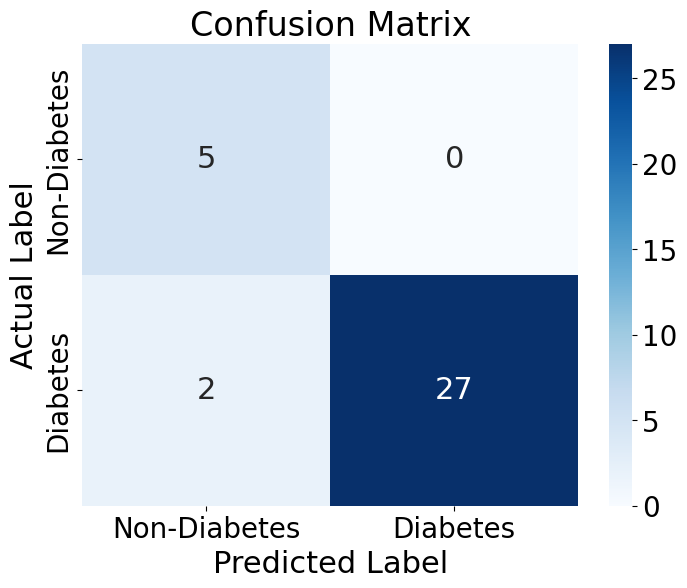

ROC AUC: 0.9724


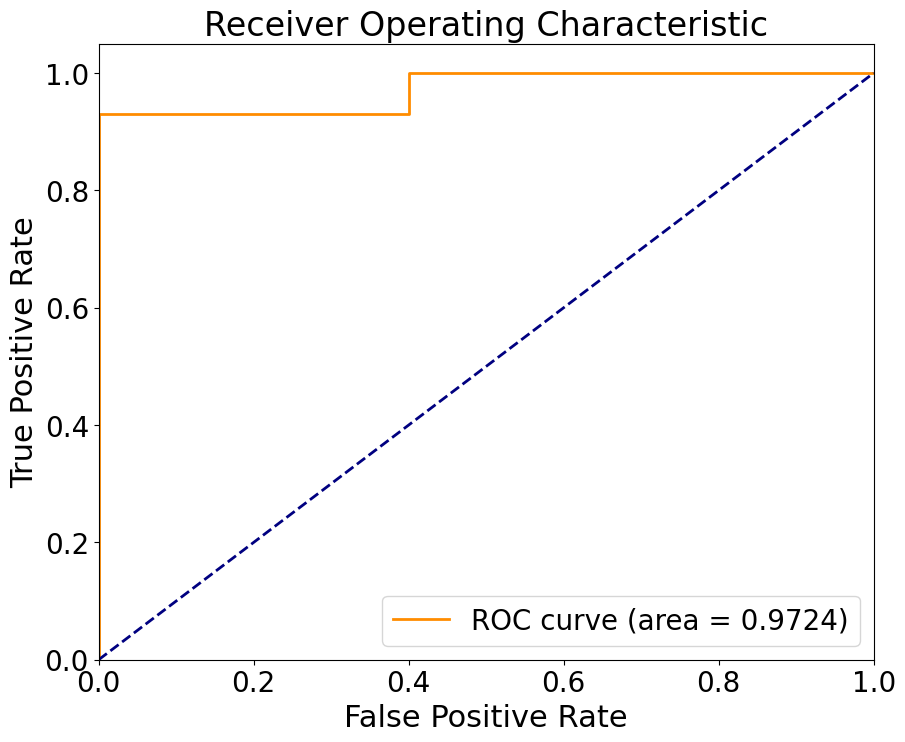

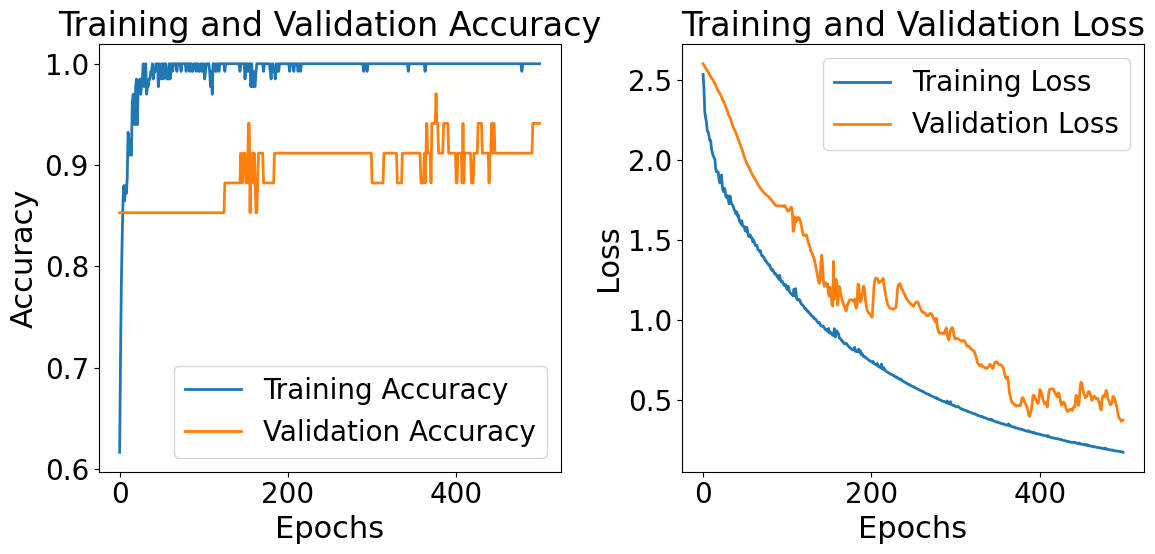

In [33]:
evaluate_model(model, X_train_termogram_left, X_train_termogram_right, X_train_tabular, 
               y_train, X_test_termogram_left, X_test_termogram_right, X_test_tabular, y_test, history)

In [47]:
model_name = "Model/model3_post_64_500.h5"
model_path = save_model(model, model_name)

Model saved as Model/model3_post_64_500.h5


In [48]:
accuracies, precisions, recalls, f1_scores, aucs = k_fold_cross_validation(
    create_model_for_kfold, 
    termograms_left, 
    termograms_right, 
    tabular_data, 
    labels,
    epochs=500
)

Results for fold 1
2/2 [==============================] - 0s 12ms/step
Fold 1 Accuracy: 0.8529
Fold 1 Precision: 0.9231
Fold 1 Recall: 0.8889
Fold 1 F1-score: 0.9057
Fold 1 ROC AUC: 0.9101

Results for fold 2
2/2 [==============================] - 0s 19ms/step
Fold 2 Accuracy: 0.9118
Fold 2 Precision: 0.9600
Fold 2 Recall: 0.9231
Fold 2 F1-score: 0.9412
Fold 2 ROC AUC: 0.9615

Results for fold 3
2/2 [==============================] - 0s 19ms/step
Fold 3 Accuracy: 0.8788
Fold 3 Precision: 0.9524
Fold 3 Recall: 0.8696
Fold 3 F1-score: 0.9091
Fold 3 ROC AUC: 0.9217

Results for fold 4
2/2 [==============================] - 0s 18ms/step
Fold 4 Accuracy: 0.8788
Fold 4 Precision: 0.8462
Fold 4 Recall: 1.0000
Fold 4 F1-score: 0.9167
Fold 4 ROC AUC: 0.9339

Results for fold 5
2/2 [==============================] - 0s 18ms/step
Fold 5 Accuracy: 0.9091
Fold 5 Precision: 1.0000
Fold 5 Recall: 0.8750
Fold 5 F1-score: 0.9333
Fold 5 ROC AUC: 0.9444

Mean Accuracy: 0.8863
Mean Precision: 0.9363
Mean 

## Solarize

In [34]:
img_dir_slr = 'Image enhancement\ehnancement new\image solarized'
history, model,\
    termograms_left, termograms_right, tabular_data, labels,\
    X_train_termogram_left, X_test_termogram_left,\
    X_train_termogram_right, X_test_termogram_right,\
    X_train_tabular, X_test_tabular,\
    y_train, y_test = run_experiment(img_dir_slr, epochs=500)

Ukuran train dan test data termogram kaki kiri: ((133, 64, 149, 3), (34, 64, 149, 3))
Ukuran train dan test data termogram kaki kanan: ((133, 64, 149, 3), (34, 64, 149, 3))
Ukuran train dan test data tabular: ((133, 13), (34, 13))
Ukuran label: ((133,), (34,))
Training time: 193.5520634651184 seconds


### Result

Test Loss: 0.6607316136360168, Test Accuracy: 0.8823529481887817
Train Loss: 0.2099570631980896, Train Accuracy: 1.0
2/2 [==============================] - 0s 19ms/step
Inference time for one sample: 0.19091248512268066 seconds
Accuracy: 0.8824
Precision: 0.9630
Recall: 0.8966
F1-score: 0.9286
Confusion Matrix:
[[ 4  1]
 [ 3 26]]


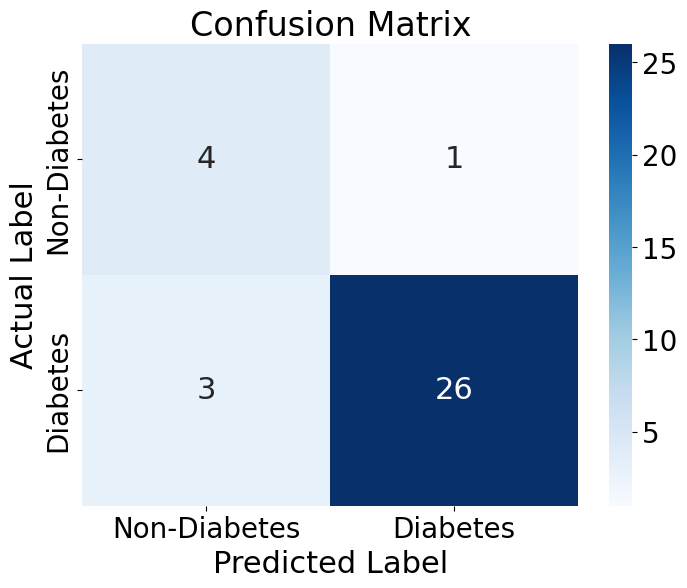

ROC AUC: 0.9724


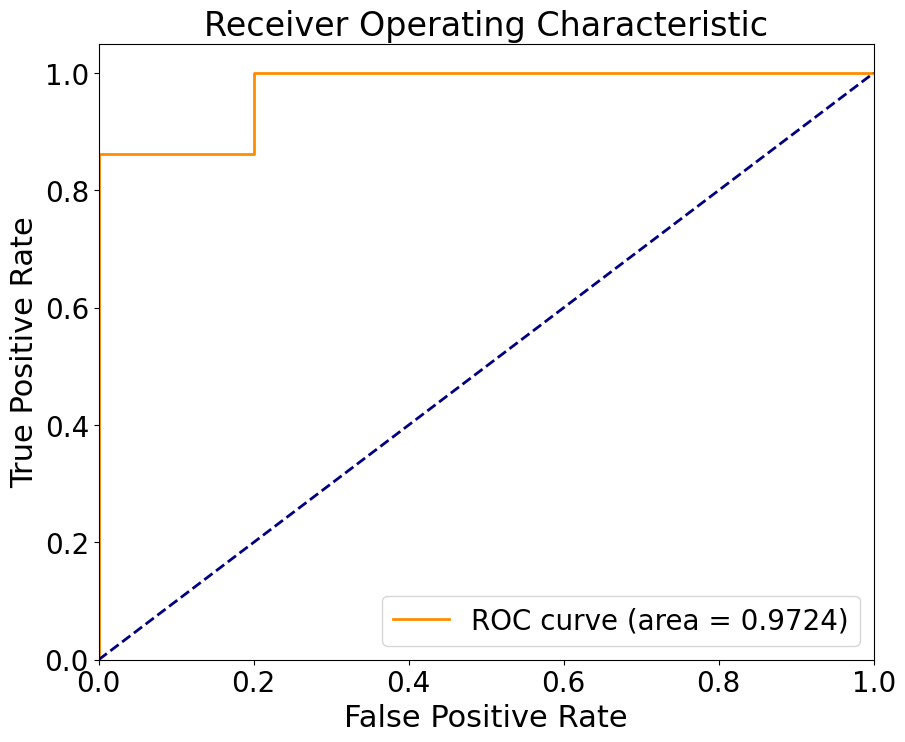

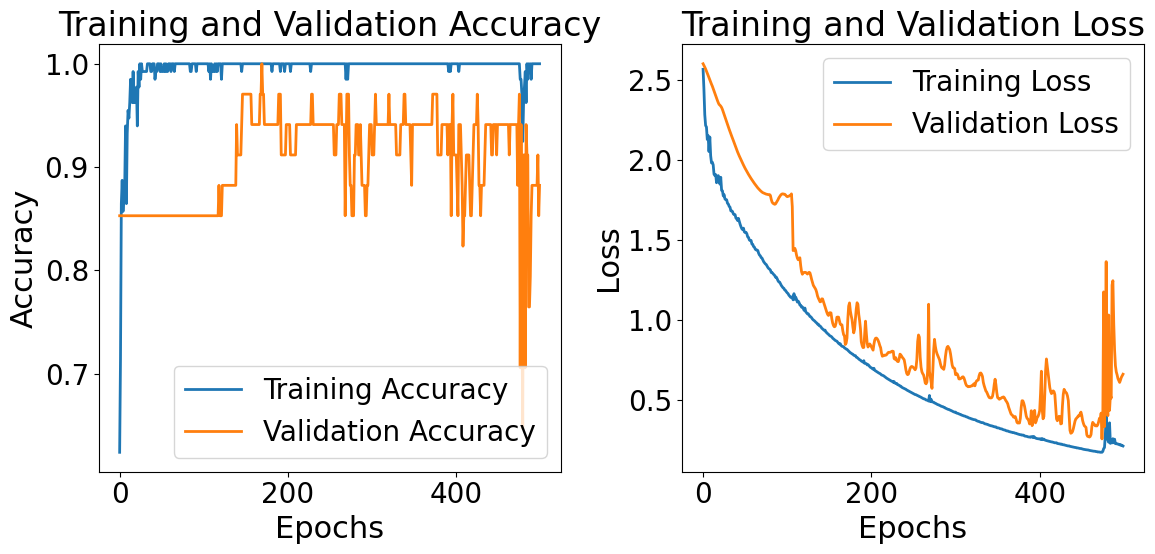

In [35]:
evaluate_model(model, X_train_termogram_left, X_train_termogram_right, X_train_tabular, 
               y_train, X_test_termogram_left, X_test_termogram_right, X_test_tabular, y_test, history)

In [51]:
model_name = "Model/model3_slr_500.h5"
model_path = save_model(model, model_name)

Model saved as Model/model3_slr_500.h5


In [52]:
accuracies, precisions, recalls, f1_scores, aucs = k_fold_cross_validation(
    create_model_for_kfold, 
    termograms_left, 
    termograms_right, 
    tabular_data, 
    labels,
    epochs=500
)

Results for fold 1
2/2 [==============================] - 0s 4ms/step
Fold 1 Accuracy: 0.8824
Fold 1 Precision: 0.9259
Fold 1 Recall: 0.9259
Fold 1 F1-score: 0.9259
Fold 1 ROC AUC: 0.9048

Results for fold 2
2/2 [==============================] - 0s 3ms/step
Fold 2 Accuracy: 0.7941
Fold 2 Precision: 0.8800
Fold 2 Recall: 0.8462
Fold 2 F1-score: 0.8627
Fold 2 ROC AUC: 0.9231

Results for fold 3
2/2 [==============================] - 0s 5ms/step
Fold 3 Accuracy: 0.9091
Fold 3 Precision: 0.9545
Fold 3 Recall: 0.9130
Fold 3 F1-score: 0.9333
Fold 3 ROC AUC: 0.9696

Results for fold 4
2/2 [==============================] - 0s 18ms/step
Fold 4 Accuracy: 0.9697
Fold 4 Precision: 0.9565
Fold 4 Recall: 1.0000
Fold 4 F1-score: 0.9778
Fold 4 ROC AUC: 0.9835

Results for fold 5
2/2 [==============================] - 0s 20ms/step
Fold 5 Accuracy: 0.9091
Fold 5 Precision: 0.9565
Fold 5 Recall: 0.9167
Fold 5 F1-score: 0.9362
Fold 5 ROC AUC: 0.9722

Mean Accuracy: 0.8929
Mean Precision: 0.9347
Mean Rec

## CLAHE

In [36]:
img_dir_clahe = 'Image enhancement\ehnancement new\image CLAHE'
history, model,\
    termograms_left, termograms_right, tabular_data, labels,\
    X_train_termogram_left, X_test_termogram_left,\
    X_train_termogram_right, X_test_termogram_right,\
    X_train_tabular, X_test_tabular,\
    y_train, y_test = run_experiment(img_dir_clahe, epochs=500)

Ukuran train dan test data termogram kaki kiri: ((133, 64, 149, 3), (34, 64, 149, 3))
Ukuran train dan test data termogram kaki kanan: ((133, 64, 149, 3), (34, 64, 149, 3))
Ukuran train dan test data tabular: ((133, 13), (34, 13))
Ukuran label: ((133,), (34,))
Training time: 193.16101217269897 seconds


### Result

Test Loss: 0.2048887312412262, Test Accuracy: 0.970588207244873
Train Loss: 0.13481023907661438, Train Accuracy: 1.0
2/2 [==============================] - 0s 18ms/step
Inference time for one sample: 0.19887566566467285 seconds
Accuracy: 0.9706
Precision: 1.0000
Recall: 0.9655
F1-score: 0.9825
Confusion Matrix:
[[ 5  0]
 [ 1 28]]


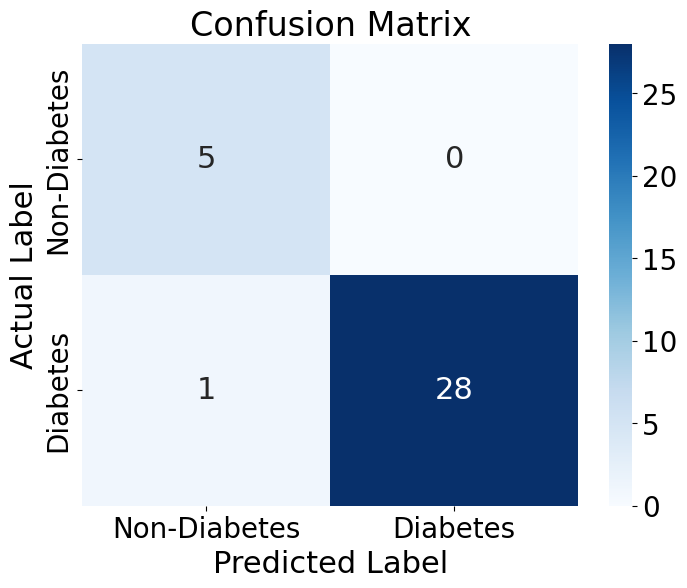

ROC AUC: 0.9931


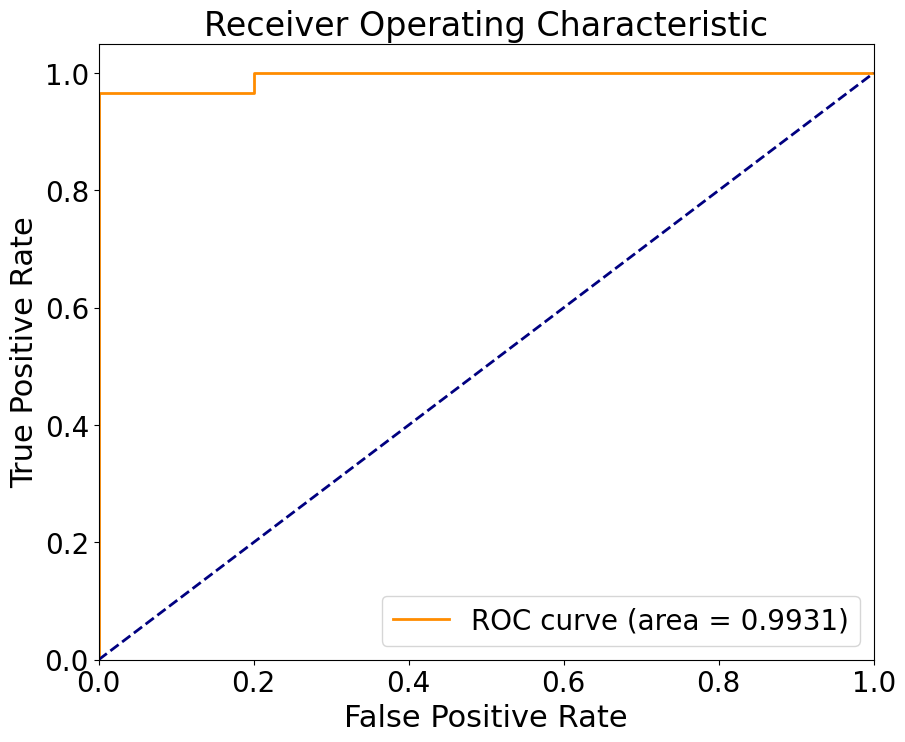

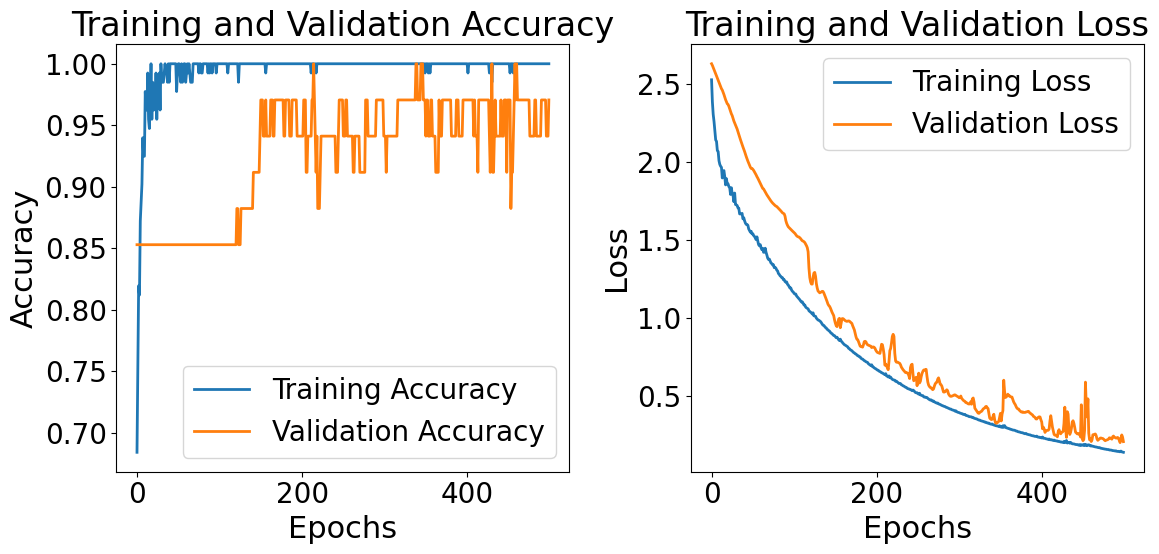

In [37]:
evaluate_model(model, X_train_termogram_left, X_train_termogram_right, X_train_tabular, 
               y_train, X_test_termogram_left, X_test_termogram_right, X_test_tabular, y_test, history)

In [55]:
model_name = "Model/model3_slr_500.h5"
model_path = save_model(model, model_name)

Model saved as Model/model3_slr_500.h5


In [56]:
accuracies, precisions, recalls, f1_scores, aucs = k_fold_cross_validation(
    create_model_for_kfold, 
    termograms_left, 
    termograms_right, 
    tabular_data, 
    labels,
    epochs=500
)

Results for fold 1
2/2 [==============================] - 0s 18ms/step
Fold 1 Accuracy: 0.9412
Fold 1 Precision: 0.9310
Fold 1 Recall: 1.0000
Fold 1 F1-score: 0.9643
Fold 1 ROC AUC: 0.9788

Results for fold 2
2/2 [==============================] - 0s 21ms/step
Fold 2 Accuracy: 0.8824
Fold 2 Precision: 0.9231
Fold 2 Recall: 0.9231
Fold 2 F1-score: 0.9231
Fold 2 ROC AUC: 0.9519

Results for fold 3
2/2 [==============================] - 0s 18ms/step
Fold 3 Accuracy: 0.9394
Fold 3 Precision: 0.9200
Fold 3 Recall: 1.0000
Fold 3 F1-score: 0.9583
Fold 3 ROC AUC: 0.9391

Results for fold 4
2/2 [==============================] - 0s 21ms/step
Fold 4 Accuracy: 0.8788
Fold 4 Precision: 0.8750
Fold 4 Recall: 0.9545
Fold 4 F1-score: 0.9130
Fold 4 ROC AUC: 0.9463

Results for fold 5
2/2 [==============================] - 0s 19ms/step
Fold 5 Accuracy: 0.9091
Fold 5 Precision: 0.9200
Fold 5 Recall: 0.9583
Fold 5 F1-score: 0.9388
Fold 5 ROC AUC: 0.9722

Mean Accuracy: 0.9102
Mean Precision: 0.9138
Mean 

## Gamma Adjusted

In [38]:
img_dir_gamma = 'Image enhancement\ehnancement new\image gamma adjusted'
history, model,\
    termograms_left, termograms_right, tabular_data, labels,\
    X_train_termogram_left, X_test_termogram_left,\
    X_train_termogram_right, X_test_termogram_right,\
    X_train_tabular, X_test_tabular,\
    y_train, y_test = run_experiment(img_dir_gamma, epochs=500)

Ukuran train dan test data termogram kaki kiri: ((133, 64, 149, 3), (34, 64, 149, 3))
Ukuran train dan test data termogram kaki kanan: ((133, 64, 149, 3), (34, 64, 149, 3))
Ukuran train dan test data tabular: ((133, 13), (34, 13))
Ukuran label: ((133,), (34,))
Training time: 194.0358874797821 seconds


### Result

Test Loss: 1.077586054801941, Test Accuracy: 0.8823529481887817
Train Loss: 0.2847728431224823, Train Accuracy: 0.9548872113227844
2/2 [==============================] - 0s 20ms/step
Inference time for one sample: 0.20438122749328613 seconds
Accuracy: 0.8824
Precision: 0.9630
Recall: 0.8966
F1-score: 0.9286
Confusion Matrix:
[[ 4  1]
 [ 3 26]]


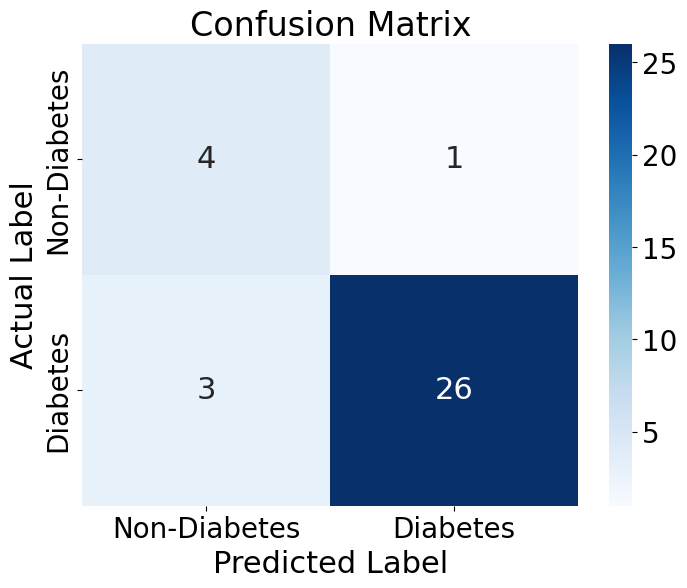

ROC AUC: 0.9517


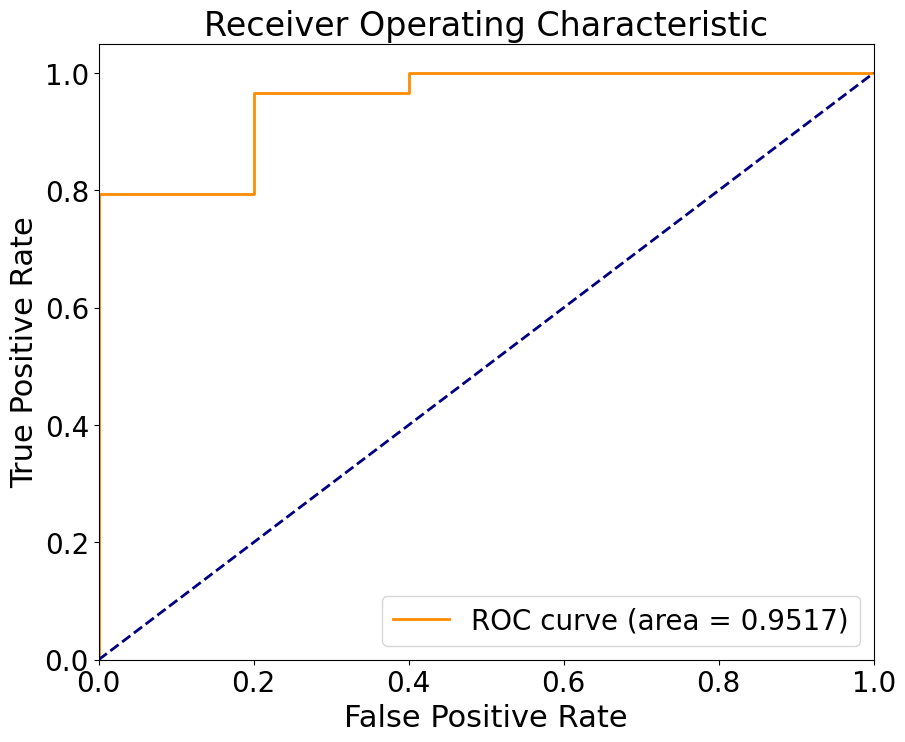

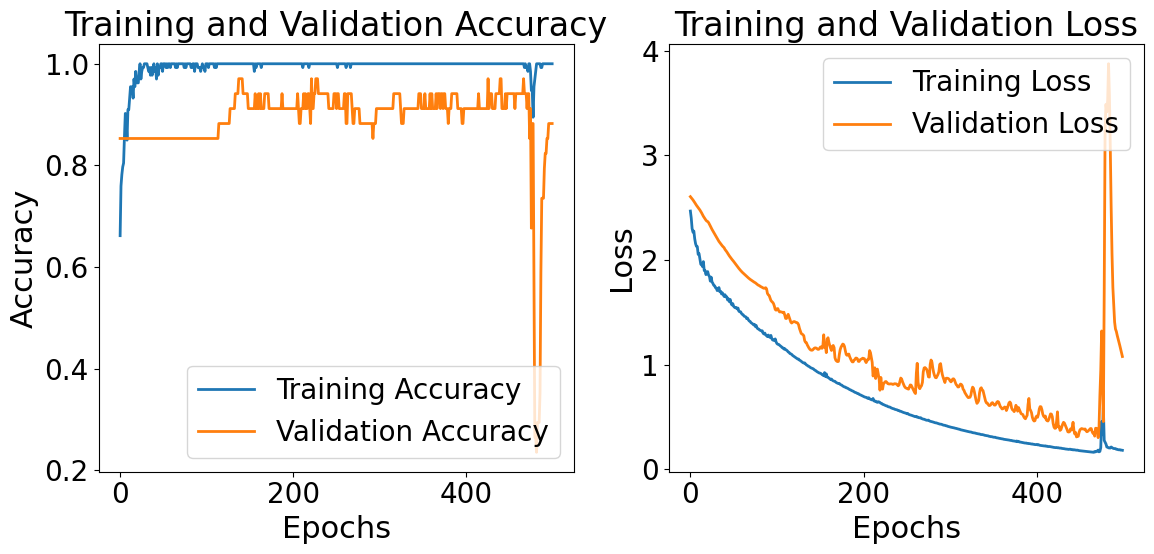

In [39]:
evaluate_model(model, X_train_termogram_left, X_train_termogram_right, X_train_tabular, 
               y_train, X_test_termogram_left, X_test_termogram_right, X_test_tabular, y_test, history)

In [21]:
model_name = "Model/model_gamma_500.h5"
model_path = save_model(model, model_name)

Model saved as Model/model_gamma_500.h5


In [22]:
accuracies, precisions, recalls, f1_scores, aucs = k_fold_cross_validation(
    create_model_for_kfold, 
    termograms_left, 
    termograms_right, 
    tabular_data, 
    labels, 
    epochs=500
)

Results for fold 1
2/2 [==============================] - 0s 17ms/step
Fold 1 Accuracy: 0.8529
Fold 1 Precision: 0.8929
Fold 1 Recall: 0.9259
Fold 1 F1-score: 0.9091
Fold 1 ROC AUC: 0.9101

Results for fold 2
2/2 [==============================] - 0s 16ms/step
Fold 2 Accuracy: 0.8235
Fold 2 Precision: 0.8846
Fold 2 Recall: 0.8846
Fold 2 F1-score: 0.8846
Fold 2 ROC AUC: 0.9327

Results for fold 3
2/2 [==============================] - 0s 18ms/step
Fold 3 Accuracy: 0.9091
Fold 3 Precision: 0.9167
Fold 3 Recall: 0.9565
Fold 3 F1-score: 0.9362
Fold 3 ROC AUC: 0.9696

Results for fold 4
2/2 [==============================] - 0s 18ms/step
Fold 4 Accuracy: 0.8788
Fold 4 Precision: 0.8462
Fold 4 Recall: 1.0000
Fold 4 F1-score: 0.9167
Fold 4 ROC AUC: 0.9215

Results for fold 5
2/2 [==============================] - 0s 17ms/step
Fold 5 Accuracy: 0.8788
Fold 5 Precision: 0.9545
Fold 5 Recall: 0.8750
Fold 5 F1-score: 0.9130
Fold 5 ROC AUC: 0.9722

Mean Accuracy: 0.8686
Mean Precision: 0.8990
Mean 